# Baseline: FCN

# 목차

1. [Imports & Global Constants](#Imports-&-Global-Constants): 학습에 필요한 라이브러리들을 임포트 하고 미션 안에서 이루어지는 학습 전반을 컨트롤 하기 위한 파라미터들을 설정합니다.
2. [Check the Size of the Dataset](#Check-the-Size-of-the-Dataset): 학습에 사용될 데이터가 잘 준비되어있는지 확인합니다.
3. [Define Dataset Class](#Define-Dataset-Class): 데이터를 원하는 형태로 불러오기 위한 Dataset 클래스를 정의하고, validation을 위한 데이터 스플릿을 진행합니다.
4. [Check Data Sample](#Check-Data-Sample): 제공된 데이터가 어떤 모습인지 확인합니다.
5. [Setup Dataloader](#Setup-Dataloader): 학습을 위해 데이터를 배치로 불러오기 위한 Dataloader를 만듭니다.
6. [Define Functions for Training](#Define-Functions-for-Training): 학습을 도와주는 함수들을 정의합니다.
7. [Training](#Training): 학습을 진행합니다.
8. [Inference](#Inference): 인퍼런스에 필요한 함수들을 정의하고, 인퍼런스를 진행합니다.
9. [Result Visualization](#Result-Visualization): 인퍼런스 결과를 확인해봅니다.
10. [To CSV](#To-CSV): 인퍼런스 결과를 제출을 위한 포맷으로 변경합니다.

# Imports & Global Constants

In [1]:
# python native
import os
import json
import random
import datetime
from functools import partial

# external library
import cv2
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.model_selection import GroupKFold
import albumentations as A
import wandb

# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torch.amp import autocast, GradScaler

# visualization
import matplotlib.pyplot as plt

/data/ephemeral/home/pybum/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
# 데이터 경로를 입력하세요

IMAGE_ROOT = "../data/train/DCM"
LABEL_ROOT = "../data/train/outputs_json"

In [3]:
CLASSES = [
    'finger-1', 'finger-2', 'finger-3', 'finger-4', 'finger-5',
    'finger-6', 'finger-7', 'finger-8', 'finger-9', 'finger-10',
    'finger-11', 'finger-12', 'finger-13', 'finger-14', 'finger-15',
    'finger-16', 'finger-17', 'finger-18', 'finger-19', 'Trapezium',
    'Trapezoid', 'Capitate', 'Hamate', 'Scaphoid', 'Lunate',
    'Triquetrum', 'Pisiform', 'Radius', 'Ulna',
]

In [4]:
CLASS2IND = {v: i for i, v in enumerate(CLASSES)}

In [5]:
IND2CLASS = {v: k for k, v in CLASS2IND.items()}

In [6]:
BATCH_SIZE = 2
LR = 1e-4
RANDOM_SEED = 21
GRAD_ACCUM = 4

NUM_EPOCHS = 100
VAL_EVERY = 2

SAVED_DIR = "checkpoints"

if not os.path.exists(SAVED_DIR):                                                           
    os.makedirs(SAVED_DIR)

# Check the Size of the Dataset

`IMAGE_ROOT` 아래에 있는 모든 폴더를 재귀적으로 순회하면서 확장자가 `.png`인 파일들을 찾습니다.

In [7]:
pngs = {
    os.path.relpath(os.path.join(root, fname), start=IMAGE_ROOT)
    for root, _dirs, files in os.walk(IMAGE_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".png"
}

In [8]:
len(pngs)

800

마찬가지로 `LABEL_ROOT` 아래에 있는 모든 폴더를 재귀적으로 순회하면서 확장자가 `.json`인 파일들을 찾습니다.

In [9]:
jsons = {
    os.path.relpath(os.path.join(root, fname), start=LABEL_ROOT)
    for root, _dirs, files in os.walk(LABEL_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".json"
}

In [10]:
len(jsons)

800

모든 `.png` 파일에 대해 `.json` pair가 존재하는지 체크합니다. 파일명에서 확장자를 제거한 set을 생성하고 두 집합의 차집합의 크기가 0인지 확인합니다.

In [11]:
jsons_fn_prefix = {os.path.splitext(fname)[0] for fname in jsons}
pngs_fn_prefix = {os.path.splitext(fname)[0] for fname in pngs}

assert len(jsons_fn_prefix - pngs_fn_prefix) == 0
assert len(pngs_fn_prefix - jsons_fn_prefix) == 0

모든 `.png` 파일에 대해 label이 존재하는 것을 확인했습니다. 이름 순으로 정렬해서 짝이 맞도록 합니다.

In [12]:
pngs = sorted(pngs)
jsons = sorted(jsons)

# Define Dataset Class

In [13]:
class XRayDataset(Dataset):
    def __init__(self, is_train=True, transforms=None):
        _filenames = np.array(pngs)
        _labelnames = np.array(jsons)
        
        # split train-valid
        # 한 폴더 안에 한 인물의 양손에 대한 `.dcm` 파일이 존재하기 때문에
        # 폴더 이름을 그룹으로 해서 GroupKFold를 수행합니다.
        # 동일 인물의 손이 train, valid에 따로 들어가는 것을 방지합니다.
        groups = [os.path.dirname(fname) for fname in _filenames]
        
        # dummy label
        ys = [0 for fname in _filenames]
        
        # 전체 데이터의 20%를 validation data로 쓰기 위해 `n_splits`를
        # 5으로 설정하여 KFold를 수행합니다.
        gkf = GroupKFold(n_splits=5,shuffle=True, random_state=RANDOM_SEED)
        
        filenames = []
        labelnames = []
        for i, (x, y) in enumerate(gkf.split(_filenames, ys, groups)):
            if is_train:
                # 0번을 validation dataset으로 사용합니다.
                if i == 0:
                    continue
                    
                filenames += list(_filenames[y])
                labelnames += list(_labelnames[y])
            
            else:
                filenames = list(_filenames[y])
                labelnames = list(_labelnames[y])
                
                # skip i > 0
                break
        
        self.filenames = filenames
        self.labelnames = labelnames
        self.is_train = is_train
        self.transforms = transforms
    
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, item):
        image_name = self.filenames[item]
        image_path = os.path.join(IMAGE_ROOT, image_name)
        
        image = cv2.imread(image_path)
        image = image / 255.
        
        label_name = self.labelnames[item]
        label_path = os.path.join(LABEL_ROOT, label_name)
        
        # (H, W, NC) 모양의 label을 생성합니다.
        label_shape = tuple(image.shape[:2]) + (len(CLASSES), )
        label = np.zeros(label_shape, dtype=np.uint8)
        
        # label 파일을 읽습니다.
        with open(label_path, "r") as f:
            annotations = json.load(f)
        annotations = annotations["annotations"]
        
        # 클래스 별로 처리합니다.
        for ann in annotations:
            c = ann["label"]
            class_ind = CLASS2IND[c]
            points = np.array(ann["points"])
            
            # polygon 포맷을 dense한 mask 포맷으로 바꿉니다.
            class_label = np.zeros(image.shape[:2], dtype=np.uint8)
            cv2.fillPoly(class_label, [points], 1)
            label[..., class_ind] = class_label
        
        if self.transforms is not None:
            result = self.transforms(image=image, mask=label)
            image, label = result["image"], result["mask"]

        # to tenser will be done later
        image = image.transpose(2, 0, 1)    # channel first 포맷으로 변경합니다.
        label = label.transpose(2, 0, 1)
        
        image = torch.from_numpy(image).float()
        label = torch.from_numpy(label).float()
            
        return image, label

# Check Data Sample

In [14]:
# 시각화를 위한 팔레트를 설정합니다.
PALETTE = [
    (220, 20, 60), (119, 11, 32), (0, 0, 142), (0, 0, 230), (106, 0, 228),
    (0, 60, 100), (0, 80, 100), (0, 0, 70), (0, 0, 192), (250, 170, 30),
    (100, 170, 30), (220, 220, 0), (175, 116, 175), (250, 0, 30), (165, 42, 42),
    (255, 77, 255), (0, 226, 252), (182, 182, 255), (0, 82, 0), (120, 166, 157),
    (110, 76, 0), (174, 57, 255), (199, 100, 0), (72, 0, 118), (255, 179, 240),
    (0, 125, 92), (209, 0, 151), (188, 208, 182), (0, 220, 176),
]

# 시각화 함수입니다. 클래스가 2개 이상인 픽셀을 고려하지는 않습니다.
def label2rgb(label):
    image_size = label.shape[1:] + (3, )
    image = np.zeros(image_size, dtype=np.uint8)
    
    for i, class_label in enumerate(label):
        image[class_label == 1] = PALETTE[i]
        
    return image

# Augmentataion

In [15]:
# tf = A.Resize(640,640)
IMAGE_SIZE= 1024
train_tf = A.Compose([
    A.ShiftScaleRotate(shift_limit=0.05,scale_limit=0.10,rotate_limit=40,border_mode=cv2.BORDER_CONSTANT,value=0,mask_value=0,p=0.35),
    A.CropNonEmptyMaskIfExists(height=IMAGE_SIZE* 0.5, width=IMAGE_SIZE* 0.5,p=0.4),
    A.RandomResizedCrop(height=IMAGE_SIZE,width=IMAGE_SIZE,scale=(0.5, 1.0),ratio=(1.0,1.0),p=0.4),
    A.CLAHE(clip_limit=1.0, p=0.3),
    # A.RandomBrightnessContrast(brightness_limit=0.08,contrast_limit=0.2,p=0.4,),
    A.ElasticTransform(alpha=40,sigma=6,border_mode=cv2.BORDER_CONSTANT,value=0,mask_value=0,approximate=False,p=0.3), 
    A.Resize(IMAGE_SIZE,IMAGE_SIZE),
])

valid_tf = A.Compose([
    A.Resize(IMAGE_SIZE,IMAGE_SIZE),
    # A.CLAHE(clip_limit=2.0, p=1.0),
])

In [16]:
train_dataset = XRayDataset(is_train=True, transforms=train_tf)
valid_dataset = XRayDataset(is_train=False, transforms=valid_tf)

# Setup Dataloader

In [17]:
train_loader = DataLoader(
    dataset=train_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    # num_workers=4,
    drop_last=True,
    num_workers=2,         
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=1,
)


valid_loader = DataLoader(
    dataset=valid_dataset, 
    batch_size=8,
    shuffle=False,
    num_workers=4,
    drop_last=False,
)

# Define Functions for Training

In [18]:
def dice_coef(y_true, y_pred):
    y_true_f = y_true.flatten(2)
    y_pred_f = y_pred.flatten(2)
    intersection = torch.sum(y_true_f * y_pred_f, -1)
    
    eps = 0.0001
    return (2. * intersection + eps) / (torch.sum(y_true_f, -1) + torch.sum(y_pred_f, -1) + eps)

In [19]:
def save_model(model, file_name='models_best.pt'):
    output_path = os.path.join(SAVED_DIR, file_name)
    torch.save(model, output_path)

In [20]:
def set_seed():
    torch.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed_all(RANDOM_SEED) # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(RANDOM_SEED)
    random.seed(RANDOM_SEED)

In [ ]:
def validation(epoch, model, data_loader, criterion, thr=0.5, use_amp=True):
    print(f'Start validation #{epoch:2d}')
    model.eval()
    model = model.cuda()

    dices = []
    with torch.no_grad():
        total_loss = 0.0
        cnt = 0

        for step, (images, masks) in tqdm(enumerate(data_loader), total=len(data_loader)):
            images, masks = images.cuda(), masks.cuda()

            # outputs = model(images)['out']
            with autocast(device_type="cuda", enabled=use_amp):
                outputs = model(pixel_values=images).logits
                outputs = F.interpolate(outputs, size=masks.shape[-2:], mode="bilinear", align_corners=False)
                loss = criterion(outputs, masks)
                
            total_loss += loss.item()
            cnt += 1

            outputs = torch.sigmoid(outputs.float())
            outputs = (outputs > thr).detach()
            masks = masks.detach()

            dice = dice_coef(outputs, masks)
            dices.append(dice.cpu())

    dices = torch.cat(dices, 0)
    dices_per_class = torch.mean(dices, 0)
    
    dice_str = "\n".join([f"{c:<12}: {d.item():.4f}" for c, d in zip(CLASSES, dices_per_class)])
    print(dice_str)

    avg_dice = torch.mean(dices_per_class).item()
    avg_val_loss = total_loss / max(cnt, 1)  

    return avg_dice, avg_val_loss, dices_per_class.detach().cpu()


In [22]:
def train(model, data_loader, val_loader, criterion, optimizer, scheduler, accum_steps=4, use_amp=True):
    print(f'Start training..')

    best_dice = 0.0
    model = model.cuda()

    scaler = GradScaler(enabled=use_amp)

    wandb.init(
        project="segmentation",
        name=f"{model.__class__.__name__}",
        config={
            "num_epochs": NUM_EPOCHS,
            "val_every": VAL_EVERY,
            "thr": 0.5,
            "optimizer": optimizer.__class__.__name__,
            "lr": optimizer.param_groups[0].get("lr", None),
            "criterion": criterion.__class__.__name__,
            "model": model.__class__.__name__,
            "accum_steps": accum_steps,
            "use_amp": use_amp,
        }
    )

    global_step = 0

    for epoch in range(NUM_EPOCHS):
        model.train()

        pbar = tqdm(data_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}", dynamic_ncols=True)

        optimizer.zero_grad(set_to_none=True)

        running_loss = 0.0
        running_count = 0

        for step, (images, masks) in enumerate(pbar):
            images, masks = images.cuda(), masks.cuda()

            #amp적용
            with autocast(device_type="cuda", enabled=use_amp):
                outputs = model(pixel_values=images).logits
                outputs = F.interpolate(outputs, size=masks.shape[-2:], mode="bilinear", align_corners=False)
                loss = criterion(outputs, masks)

            running_loss += loss.item()
            running_count += 1
            
            # 이번 스텝이 업데이트 시점인지/에폭 마지막인지 판단
            is_update = ((step + 1) % accum_steps == 0)
            is_last = ((step + 1) == len(data_loader))


            # AMP + grad accumulation
            scaler.scale(loss / accum_steps).backward()

            # 업데이트 시점 또는 마지막 남은 배치에서 step
            if is_update or is_last:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad(set_to_none=True)

                global_step += 1
                current_lr = optimizer.param_groups[0]["lr"]

                # accum 구간 평균 loss 로깅
                avg_loss = running_loss / running_count
                wandb.log(
                    {"train/loss": avg_loss, "train/lr": current_lr, "epoch": epoch + 1},
                    step=global_step
                )

                pbar.set_postfix(loss=f"{avg_loss:.4f}")

                running_loss = 0.0
                running_count = 0
            else:
                pbar.set_postfix(loss=f"{loss.item():.4f}")

            if (step + 1) % 25 == 0:
                tqdm.write(
                    f'{datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")} | '
                    f'Epoch [{epoch+1}/{NUM_EPOCHS}], '
                    f'Step [{step+1}/{len(data_loader)}], '
                    f'Loss: {round(loss.item(), 4)}'
                )

        # scheduler.step()
        pbar.close()

        if (epoch + 1) % VAL_EVERY == 0:
            log_dict = {}
            dice, val_loss, dices_pc = validation(epoch + 1, model, val_loader, criterion, use_amp=use_amp)

            wandb.log(
                {"val/loss": val_loss, "val/dice": dice, "epoch": epoch + 1},
                step=global_step
            )

            for c, d in zip(CLASSES, dices_pc):
                log_dict[f"val/dice/{c}"] = float(d)
            wandb.log(log_dict)

            if best_dice < dice:
                tqdm.write(f"Best performance at epoch {epoch+1}: {best_dice:.4f} -> {dice:.4f}")
                tqdm.write(f"val_loss: {val_loss:.4f}")
                best_dice = dice
                save_model(model, file_name='segformer_base_b5.pt')

    wandb.finish()


# Losses

In [23]:
# single
# ABeDice안에서 dice를 사용하기 때문에 dice안에서는 sigmoid(pred)하면 안됨
def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()  
    
    intersection = (pred * target).sum(dim=2).sum(dim=2)
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) +   target.sum(dim=2).sum(dim=2) + smooth)))

    return loss.mean()
    
def ABeDice(pred, target, alpha=1, beta=1, smooth=1e-5):
    pred= pred.contiguous()
    target= target.contiguous()
    pred = torch.sigmoid(pred)
    
    p = pred
    t =1.0 

    for _ in range(beta):
        t = 1- p**t
    erc = p ** (alpha * t)

    return dice_loss(erc, target, smooth)

wrist_indices = [
    CLASSES.index("Trapezium"),
    CLASSES.index("Trapezoid"),
    CLASSES.index("Capitate"),
    CLASSES.index("Hamate"),
    CLASSES.index("Scaphoid"),
    CLASSES.index("Lunate"),
    CLASSES.index("Triquetrum"),
    CLASSES.index("Pisiform"),
]

def focal_tversky_loss(pred, target, alpha=0.5, beta=0.5, gamma=1.25, smooth=1e-6, class_idx=None):
    pred= pred.contiguous()
    target= target.contiguous()

    p=torch.sigmoid(pred)
    y=target

    if class_idx is not None:
        p= p[:, class_idx, ...]
        y= y[:, class_idx, ...]
    
    dims = (2, 3)
    tp = (p * y).sum(dim=dims)
    fp = (p * (1 - y)).sum(dim=dims)
    fn = ((1 - p) * y).sum(dim=dims)

    tversky= (tp+smooth) / (tp + alpha * fp + beta * fn+ smooth)
    loss= torch.pow((1-tversky), gamma)
    return loss.mean()

# multi 
def bce_dice(pred, target, bce_weight = 0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)
    pred = torch.sigmoid(pred)
    dice = dice_loss(pred, target)
    loss = bce* bce_weight + dice* (1 - bce_weight)
    return loss

def bce_abedice(pred, target, bce_weight = 0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)
    dice = ABeDice(pred, target)
    loss = bce* bce_weight + dice* (1 - bce_weight)
    return loss
    
def bce_ftversky(pred, target, bce_weight = 0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)
    dice = focal_tversky_loss(pred, target, alpha=0.5, beta=0.5, gamma=1.25, class_idx=None)
    loss = bce* bce_weight + dice* (1 - bce_weight)
    return loss
    
def ABeDice_ftversky(pred, target, wrist_idx=wrist_indices, lam=2):
    base = ABeDice(pred,target, alpha=1, beta=1)
    wrist = focal_tversky_loss(pred, target, alpha=0.5, beta=0.5, gamma=1.25, class_idx=wrist_idx)
    return base + lam * wrist
    
def bce_ABeDice_ftversky(pred, target, wrist_idx=wrist_indices,bce_weight=0.33, ABe_weight=0.33, ft_weight=0.33):
    bce = F.binary_cross_entropy_with_logits(pred, target)
    ABe = ABeDice(pred, target, alpha=1, beta=1)
    ft= focal_tversky_loss(pred, target, alpha=0.5, beta=0.5, gamma=1.25, class_idx=wrist_idx)
    loss = bce* bce_weight + ABe * ABe_weight + ft * ft_weight

    return loss    

# Training

In [24]:
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor
NUM_CLASSES = 29  

# nvidia/segformer-b3-finetuned-cityscapes-1024-1024
# nvidia/segformer-b5-finetuned-ade-640-640
# nvidia/segformer-b1-finetuned-ade-512-512
# nvidia/segformer-b2-finetuned-cityscapes-1024-1024


model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/segformer-b5-finetuned-cityscapes-1024-1024",
    num_labels=NUM_CLASSES,
    ignore_mismatched_sizes=True
)
# model = models.segmentation.deeplabv3_resnet50(weights='DeepLabV3_ResNet50_Weights.DEFAULT')


# print(model.classifier)
# output class 개수를 dataset에 맞도록 수정합니다.
# model.classifier[4] = nn.Conv2d(512, len(CLASSES), kernel_size=1)
# model.classifier[4] = nn.Conv2d(256, len(CLASSES), kernel_size=1)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b5-finetuned-cityscapes-1024-1024 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([19, 768, 1, 1]) in the checkpoint and torch.Size([29, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([19]) in the checkpoint and torch.Size([29]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
# Loss function을 정의합니다.
# criterion = nn.BCEWithLogitsLoss()
# criterion = calc_loss
# criterion = ABeDice

# criterion = ABeDice_ftversky
# criterion = bce_ABeDice_ftversky

# criterion = bce_abedice
criterion = bce_ftversky
# Optimizer를 정의합니다.
optimizer = optim.AdamW(params=model.parameters(), lr=LR, weight_decay=1e-4)

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=NUM_EPOCHS,eta_min=3e-5)



In [26]:
# 시드를 설정합니다.
set_seed()

In [27]:
train(model, train_loader, valid_loader, criterion, optimizer, scheduler, GRAD_ACCUM, use_amp=True)

Start training..


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


Epoch 1/70:   0%|                                                                               | 0/320 [00:00…

2025-12-25 03:08:16 | Epoch [1/70], Step [25/320], Loss: 0.8627
2025-12-25 03:08:59 | Epoch [1/70], Step [50/320], Loss: 0.8417
2025-12-25 03:09:40 | Epoch [1/70], Step [75/320], Loss: 0.8277
2025-12-25 03:10:20 | Epoch [1/70], Step [100/320], Loss: 0.8091
2025-12-25 03:11:00 | Epoch [1/70], Step [125/320], Loss: 0.7955
2025-12-25 03:11:39 | Epoch [1/70], Step [150/320], Loss: 0.7794
2025-12-25 03:12:19 | Epoch [1/70], Step [175/320], Loss: 0.7722
2025-12-25 03:13:00 | Epoch [1/70], Step [200/320], Loss: 0.7588
2025-12-25 03:13:43 | Epoch [1/70], Step [225/320], Loss: 0.7515
2025-12-25 03:14:25 | Epoch [1/70], Step [250/320], Loss: 0.74
2025-12-25 03:15:06 | Epoch [1/70], Step [275/320], Loss: 0.7336
2025-12-25 03:15:45 | Epoch [1/70], Step [300/320], Loss: 0.7258


Epoch 2/70:   0%|                                                                               | 0/320 [00:00…

2025-12-25 03:17:02 | Epoch [2/70], Step [25/320], Loss: 0.7153
2025-12-25 03:17:43 | Epoch [2/70], Step [50/320], Loss: 0.7097
2025-12-25 03:18:23 | Epoch [2/70], Step [75/320], Loss: 0.7051
2025-12-25 03:19:04 | Epoch [2/70], Step [100/320], Loss: 0.6908
2025-12-25 03:19:46 | Epoch [2/70], Step [125/320], Loss: 0.6876
2025-12-25 03:20:28 | Epoch [2/70], Step [150/320], Loss: 0.6888
2025-12-25 03:21:11 | Epoch [2/70], Step [175/320], Loss: 0.6871
2025-12-25 03:21:51 | Epoch [2/70], Step [200/320], Loss: 0.6803
2025-12-25 03:22:32 | Epoch [2/70], Step [225/320], Loss: 0.6716
2025-12-25 03:23:12 | Epoch [2/70], Step [250/320], Loss: 0.6643
2025-12-25 03:23:53 | Epoch [2/70], Step [275/320], Loss: 0.6628
2025-12-25 03:24:32 | Epoch [2/70], Step [300/320], Loss: 0.6441
Start validation # 2


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.0000
finger-2    : 0.0000
finger-3    : 0.0000
finger-4    : 0.0000
finger-5    : 0.0000
finger-6    : 0.0000
finger-7    : 0.0000
finger-8    : 0.0000
finger-9    : 0.0000
finger-10   : 0.0000
finger-11   : 0.0000
finger-12   : 0.0000
finger-13   : 0.0000
finger-14   : 0.0000
finger-15   : 0.0000
finger-16   : 0.0000
finger-17   : 0.0000
finger-18   : 0.0000
finger-19   : 0.0000
Trapezium   : 0.6415
Trapezoid   : 0.5771
Capitate    : 0.7688
Hamate      : 0.7207
Scaphoid    : 0.7175
Lunate      : 0.6305
Triquetrum  : 0.7128
Pisiform    : 0.6635
Radius      : 0.8912
Ulna        : 0.0000
Best performance at epoch 2: 0.0000 -> 0.2181
val_loss: 0.6555


Epoch 3/70:   0%|                                                                               | 0/320 [00:00…

2025-12-25 03:26:51 | Epoch [3/70], Step [25/320], Loss: 0.6377
2025-12-25 03:27:35 | Epoch [3/70], Step [50/320], Loss: 0.6327
2025-12-25 03:28:16 | Epoch [3/70], Step [75/320], Loss: 0.6238
2025-12-25 03:28:56 | Epoch [3/70], Step [100/320], Loss: 0.6064
2025-12-25 03:29:37 | Epoch [3/70], Step [125/320], Loss: 0.5793
2025-12-25 03:30:22 | Epoch [3/70], Step [150/320], Loss: 0.5871
2025-12-25 03:31:02 | Epoch [3/70], Step [175/320], Loss: 0.5739
2025-12-25 03:31:44 | Epoch [3/70], Step [200/320], Loss: 0.5718
2025-12-25 03:32:28 | Epoch [3/70], Step [225/320], Loss: 0.5258
2025-12-25 03:33:11 | Epoch [3/70], Step [250/320], Loss: 0.5134
2025-12-25 03:33:50 | Epoch [3/70], Step [275/320], Loss: 0.4846
2025-12-25 03:34:33 | Epoch [3/70], Step [300/320], Loss: 0.4951


Epoch 4/70:   0%|                                                                               | 0/320 [00:00…

2025-12-25 03:35:55 | Epoch [4/70], Step [25/320], Loss: 0.4218
2025-12-25 03:36:35 | Epoch [4/70], Step [50/320], Loss: 0.4075
2025-12-25 03:37:18 | Epoch [4/70], Step [75/320], Loss: 0.3997
2025-12-25 03:37:57 | Epoch [4/70], Step [100/320], Loss: 0.3915
2025-12-25 03:38:40 | Epoch [4/70], Step [125/320], Loss: 0.3753
2025-12-25 03:39:20 | Epoch [4/70], Step [150/320], Loss: 0.341
2025-12-25 03:40:01 | Epoch [4/70], Step [175/320], Loss: 0.3344
2025-12-25 03:40:45 | Epoch [4/70], Step [200/320], Loss: 0.3209
2025-12-25 03:41:27 | Epoch [4/70], Step [225/320], Loss: 0.3229
2025-12-25 03:42:11 | Epoch [4/70], Step [250/320], Loss: 0.3131
2025-12-25 03:42:52 | Epoch [4/70], Step [275/320], Loss: 0.2943
2025-12-25 03:43:36 | Epoch [4/70], Step [300/320], Loss: 0.3048
Start validation # 4


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.0000
finger-2    : 0.0000
finger-3    : 0.0000
finger-4    : 0.0000
finger-5    : 0.0000
finger-6    : 0.0000
finger-7    : 0.0005
finger-8    : 0.0000
finger-9    : 0.0000
finger-10   : 0.0000
finger-11   : 0.8976
finger-12   : 0.0000
finger-13   : 0.0000
finger-14   : 0.0000
finger-15   : 0.0000
finger-16   : 0.0000
finger-17   : 0.0000
finger-18   : 0.0000
finger-19   : 0.0000
Trapezium   : 0.9108
Trapezoid   : 0.8715
Capitate    : 0.9296
Hamate      : 0.9206
Scaphoid    : 0.9309
Lunate      : 0.9182
Triquetrum  : 0.8796
Pisiform    : 0.8293
Radius      : 0.9307
Ulna        : 0.9324
Best performance at epoch 4: 0.2181 -> 0.3432
val_loss: 0.2900


Epoch 5/70:   0%|                                                                               | 0/320 [00:00…

2025-12-25 03:45:56 | Epoch [5/70], Step [25/320], Loss: 0.276
2025-12-25 03:46:36 | Epoch [5/70], Step [50/320], Loss: 0.2801
2025-12-25 03:47:20 | Epoch [5/70], Step [75/320], Loss: 0.2763
2025-12-25 03:48:04 | Epoch [5/70], Step [100/320], Loss: 0.2716
2025-12-25 03:48:45 | Epoch [5/70], Step [125/320], Loss: 0.2819
2025-12-25 03:49:29 | Epoch [5/70], Step [150/320], Loss: 0.2655
2025-12-25 03:50:11 | Epoch [5/70], Step [175/320], Loss: 0.2636
2025-12-25 03:50:52 | Epoch [5/70], Step [200/320], Loss: 0.2559
2025-12-25 03:51:35 | Epoch [5/70], Step [225/320], Loss: 0.2594
2025-12-25 03:52:17 | Epoch [5/70], Step [250/320], Loss: 0.25
2025-12-25 03:52:57 | Epoch [5/70], Step [275/320], Loss: 0.2488
2025-12-25 03:53:39 | Epoch [5/70], Step [300/320], Loss: 0.2504


Epoch 6/70:   0%|                                                                               | 0/320 [00:00…

2025-12-25 03:54:58 | Epoch [6/70], Step [25/320], Loss: 0.2278
2025-12-25 03:55:41 | Epoch [6/70], Step [50/320], Loss: 0.2306
2025-12-25 03:56:22 | Epoch [6/70], Step [75/320], Loss: 0.2434
2025-12-25 03:57:02 | Epoch [6/70], Step [100/320], Loss: 0.2261
2025-12-25 03:57:41 | Epoch [6/70], Step [125/320], Loss: 0.2237
2025-12-25 03:58:23 | Epoch [6/70], Step [150/320], Loss: 0.2198
2025-12-25 03:59:07 | Epoch [6/70], Step [175/320], Loss: 0.2203
2025-12-25 03:59:49 | Epoch [6/70], Step [200/320], Loss: 0.2137
2025-12-25 04:00:31 | Epoch [6/70], Step [225/320], Loss: 0.2064
2025-12-25 04:01:11 | Epoch [6/70], Step [250/320], Loss: 0.2012
2025-12-25 04:01:54 | Epoch [6/70], Step [275/320], Loss: 0.1986
2025-12-25 04:02:37 | Epoch [6/70], Step [300/320], Loss: 0.1965
Start validation # 6


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.0000
finger-2    : 0.9026
finger-3    : 0.9366
finger-4    : 0.0000
finger-5    : 0.0000
finger-6    : 0.9440
finger-7    : 0.9397
finger-8    : 0.0000
finger-9    : 0.0000
finger-10   : 0.9545
finger-11   : 0.9421
finger-12   : 0.0000
finger-13   : 0.0000
finger-14   : 0.3414
finger-15   : 0.9247
finger-16   : 0.0000
finger-17   : 0.0000
finger-18   : 0.6499
finger-19   : 0.9415
Trapezium   : 0.9273
Trapezoid   : 0.8880
Capitate    : 0.9386
Hamate      : 0.9300
Scaphoid    : 0.9471
Lunate      : 0.9325
Triquetrum  : 0.9252
Pisiform    : 0.8786
Radius      : 0.9501
Ulna        : 0.9493
Best performance at epoch 6: 0.3432 -> 0.6118
val_loss: 0.1924


Epoch 7/70:   0%|                                                                               | 0/320 [00:00…

2025-12-25 04:05:05 | Epoch [7/70], Step [25/320], Loss: 0.1792
2025-12-25 04:05:45 | Epoch [7/70], Step [50/320], Loss: 0.1863
2025-12-25 04:06:24 | Epoch [7/70], Step [75/320], Loss: 0.1853
2025-12-25 04:07:07 | Epoch [7/70], Step [100/320], Loss: 0.1789
2025-12-25 04:07:48 | Epoch [7/70], Step [125/320], Loss: 0.1746
2025-12-25 04:08:27 | Epoch [7/70], Step [150/320], Loss: 0.1724
2025-12-25 04:09:11 | Epoch [7/70], Step [175/320], Loss: 0.1719
2025-12-25 04:09:52 | Epoch [7/70], Step [200/320], Loss: 0.1673
2025-12-25 04:10:31 | Epoch [7/70], Step [225/320], Loss: 0.158
2025-12-25 04:11:15 | Epoch [7/70], Step [250/320], Loss: 0.1551
2025-12-25 04:11:55 | Epoch [7/70], Step [275/320], Loss: 0.1622
2025-12-25 04:12:36 | Epoch [7/70], Step [300/320], Loss: 0.1574


Epoch 8/70:   0%|                                                                               | 0/320 [00:00…

2025-12-25 04:13:58 | Epoch [8/70], Step [25/320], Loss: 0.1561
2025-12-25 04:14:40 | Epoch [8/70], Step [50/320], Loss: 0.1463
2025-12-25 04:15:22 | Epoch [8/70], Step [75/320], Loss: 0.1531
2025-12-25 04:16:03 | Epoch [8/70], Step [100/320], Loss: 0.1516
2025-12-25 04:16:43 | Epoch [8/70], Step [125/320], Loss: 0.1445
2025-12-25 04:17:25 | Epoch [8/70], Step [150/320], Loss: 0.1414
2025-12-25 04:18:05 | Epoch [8/70], Step [175/320], Loss: 0.138
2025-12-25 04:18:46 | Epoch [8/70], Step [200/320], Loss: 0.1401
2025-12-25 04:19:26 | Epoch [8/70], Step [225/320], Loss: 0.139
2025-12-25 04:20:08 | Epoch [8/70], Step [250/320], Loss: 0.1363
2025-12-25 04:20:52 | Epoch [8/70], Step [275/320], Loss: 0.1383
2025-12-25 04:21:35 | Epoch [8/70], Step [300/320], Loss: 0.1328
Start validation # 8


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.0000
finger-2    : 0.9579
finger-3    : 0.9549
finger-4    : 0.0000
finger-5    : 0.0000
finger-6    : 0.9630
finger-7    : 0.9601
finger-8    : 0.0000
finger-9    : 0.9430
finger-10   : 0.9644
finger-11   : 0.9615
finger-12   : 0.0000
finger-13   : 0.9119
finger-14   : 0.9644
finger-15   : 0.9499
finger-16   : 0.0000
finger-17   : 0.0000
finger-18   : 0.9511
finger-19   : 0.9570
Trapezium   : 0.9322
Trapezoid   : 0.8931
Capitate    : 0.9428
Hamate      : 0.9360
Scaphoid    : 0.9539
Lunate      : 0.9402
Triquetrum  : 0.9314
Pisiform    : 0.8820
Radius      : 0.9671
Ulna        : 0.9575
Best performance at epoch 8: 0.6118 -> 0.7164
val_loss: 0.1332


Epoch 9/70:   0%|                                                                               | 0/320 [00:00…

2025-12-25 04:23:56 | Epoch [9/70], Step [25/320], Loss: 0.1288
2025-12-25 04:24:37 | Epoch [9/70], Step [50/320], Loss: 0.1352
2025-12-25 04:25:19 | Epoch [9/70], Step [75/320], Loss: 0.1234
2025-12-25 04:26:01 | Epoch [9/70], Step [100/320], Loss: 0.1213
2025-12-25 04:26:46 | Epoch [9/70], Step [125/320], Loss: 0.1235
2025-12-25 04:27:29 | Epoch [9/70], Step [150/320], Loss: 0.1133
2025-12-25 04:28:10 | Epoch [9/70], Step [175/320], Loss: 0.1199
2025-12-25 04:28:52 | Epoch [9/70], Step [200/320], Loss: 0.1091
2025-12-25 04:29:34 | Epoch [9/70], Step [225/320], Loss: 0.1145
2025-12-25 04:30:15 | Epoch [9/70], Step [250/320], Loss: 0.108
2025-12-25 04:30:56 | Epoch [9/70], Step [275/320], Loss: 0.1035
2025-12-25 04:31:38 | Epoch [9/70], Step [300/320], Loss: 0.1024


Epoch 10/70:   0%|                                                                              | 0/320 [00:00…

2025-12-25 04:32:59 | Epoch [10/70], Step [25/320], Loss: 0.0997
2025-12-25 04:33:42 | Epoch [10/70], Step [50/320], Loss: 0.0935
2025-12-25 04:34:22 | Epoch [10/70], Step [75/320], Loss: 0.0971
2025-12-25 04:35:04 | Epoch [10/70], Step [100/320], Loss: 0.0943
2025-12-25 04:35:46 | Epoch [10/70], Step [125/320], Loss: 0.0927
2025-12-25 04:36:29 | Epoch [10/70], Step [150/320], Loss: 0.0891
2025-12-25 04:37:11 | Epoch [10/70], Step [175/320], Loss: 0.0861
2025-12-25 04:37:53 | Epoch [10/70], Step [200/320], Loss: 0.0873
2025-12-25 04:38:37 | Epoch [10/70], Step [225/320], Loss: 0.0866
2025-12-25 04:39:19 | Epoch [10/70], Step [250/320], Loss: 0.0864
2025-12-25 04:39:59 | Epoch [10/70], Step [275/320], Loss: 0.0808
2025-12-25 04:40:37 | Epoch [10/70], Step [300/320], Loss: 0.0799
Start validation #10


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9390
finger-2    : 0.9524
finger-3    : 0.9661
finger-4    : 0.9228
finger-5    : 0.9515
finger-6    : 0.9679
finger-7    : 0.9676
finger-8    : 0.8539
finger-9    : 0.9588
finger-10   : 0.9718
finger-11   : 0.9596
finger-12   : 0.2618
finger-13   : 0.9562
finger-14   : 0.9702
finger-15   : 0.9577
finger-16   : 0.0000
finger-17   : 0.9282
finger-18   : 0.9562
finger-19   : 0.9626
Trapezium   : 0.9347
Trapezoid   : 0.9015
Capitate    : 0.9479
Hamate      : 0.9378
Scaphoid    : 0.9571
Lunate      : 0.9456
Triquetrum  : 0.9385
Pisiform    : 0.8955
Radius      : 0.9666
Ulna        : 0.9655
Best performance at epoch 10: 0.7164 -> 0.8895
val_loss: 0.0802


Epoch 11/70:   0%|                                                                              | 0/320 [00:00…

2025-12-25 04:42:59 | Epoch [11/70], Step [25/320], Loss: 0.0793
2025-12-25 04:43:40 | Epoch [11/70], Step [50/320], Loss: 0.0736
2025-12-25 04:44:22 | Epoch [11/70], Step [75/320], Loss: 0.0756
2025-12-25 04:45:02 | Epoch [11/70], Step [100/320], Loss: 0.0659
2025-12-25 04:45:45 | Epoch [11/70], Step [125/320], Loss: 0.0647
2025-12-25 04:46:29 | Epoch [11/70], Step [150/320], Loss: 0.0628
2025-12-25 04:47:08 | Epoch [11/70], Step [175/320], Loss: 0.064
2025-12-25 04:47:50 | Epoch [11/70], Step [200/320], Loss: 0.0571
2025-12-25 04:48:33 | Epoch [11/70], Step [225/320], Loss: 0.06
2025-12-25 04:49:14 | Epoch [11/70], Step [250/320], Loss: 0.0506
2025-12-25 04:49:55 | Epoch [11/70], Step [275/320], Loss: 0.0496
2025-12-25 04:50:36 | Epoch [11/70], Step [300/320], Loss: 0.0453


Epoch 12/70:   0%|                                                                              | 0/320 [00:00…

2025-12-25 04:51:54 | Epoch [12/70], Step [25/320], Loss: 0.0433
2025-12-25 04:52:34 | Epoch [12/70], Step [50/320], Loss: 0.0395
2025-12-25 04:53:12 | Epoch [12/70], Step [75/320], Loss: 0.0485
2025-12-25 04:53:55 | Epoch [12/70], Step [100/320], Loss: 0.0395
2025-12-25 04:54:35 | Epoch [12/70], Step [125/320], Loss: 0.0482
2025-12-25 04:55:16 | Epoch [12/70], Step [150/320], Loss: 0.0458
2025-12-25 04:55:59 | Epoch [12/70], Step [175/320], Loss: 0.0512
2025-12-25 04:56:38 | Epoch [12/70], Step [200/320], Loss: 0.0399
2025-12-25 04:57:20 | Epoch [12/70], Step [225/320], Loss: 0.0403
2025-12-25 04:58:02 | Epoch [12/70], Step [250/320], Loss: 0.0353
2025-12-25 04:58:45 | Epoch [12/70], Step [275/320], Loss: 0.0368
2025-12-25 04:59:27 | Epoch [12/70], Step [300/320], Loss: 0.0386
Start validation #12


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9427
finger-2    : 0.9691
finger-3    : 0.9684
finger-4    : 0.9593
finger-5    : 0.9568
finger-6    : 0.9750
finger-7    : 0.9688
finger-8    : 0.9625
finger-9    : 0.9653
finger-10   : 0.9744
finger-11   : 0.9645
finger-12   : 0.9455
finger-13   : 0.9663
finger-14   : 0.9703
finger-15   : 0.9637
finger-16   : 0.9393
finger-17   : 0.9369
finger-18   : 0.9709
finger-19   : 0.9682
Trapezium   : 0.9366
Trapezoid   : 0.9042
Capitate    : 0.9486
Hamate      : 0.9378
Scaphoid    : 0.9571
Lunate      : 0.9445
Triquetrum  : 0.9418
Pisiform    : 0.8981
Radius      : 0.9736
Ulna        : 0.9708
Best performance at epoch 12: 0.8895 -> 0.9545
val_loss: 0.0408


Epoch 13/70:   0%|                                                                              | 0/320 [00:00…

2025-12-25 05:01:52 | Epoch [13/70], Step [25/320], Loss: 0.0429
2025-12-25 05:02:34 | Epoch [13/70], Step [50/320], Loss: 0.0466
2025-12-25 05:03:17 | Epoch [13/70], Step [75/320], Loss: 0.0361
2025-12-25 05:03:58 | Epoch [13/70], Step [100/320], Loss: 0.0383
2025-12-25 05:04:39 | Epoch [13/70], Step [125/320], Loss: 0.0409
2025-12-25 05:05:22 | Epoch [13/70], Step [150/320], Loss: 0.0447
2025-12-25 05:06:01 | Epoch [13/70], Step [175/320], Loss: 0.0356
2025-12-25 05:06:41 | Epoch [13/70], Step [200/320], Loss: 0.0328
2025-12-25 05:07:22 | Epoch [13/70], Step [225/320], Loss: 0.0365
2025-12-25 05:08:04 | Epoch [13/70], Step [250/320], Loss: 0.0344
2025-12-25 05:08:47 | Epoch [13/70], Step [275/320], Loss: 0.0368
2025-12-25 05:09:27 | Epoch [13/70], Step [300/320], Loss: 0.03


Epoch 14/70:   0%|                                                                              | 0/320 [00:00…

2025-12-25 05:10:46 | Epoch [14/70], Step [25/320], Loss: 0.031
2025-12-25 05:11:27 | Epoch [14/70], Step [50/320], Loss: 0.0298
2025-12-25 05:12:10 | Epoch [14/70], Step [75/320], Loss: 0.1069
2025-12-25 05:12:50 | Epoch [14/70], Step [100/320], Loss: 0.0315
2025-12-25 05:13:34 | Epoch [14/70], Step [125/320], Loss: 0.0315
2025-12-25 05:14:15 | Epoch [14/70], Step [150/320], Loss: 0.0339
2025-12-25 05:14:58 | Epoch [14/70], Step [175/320], Loss: 0.0622
2025-12-25 05:15:40 | Epoch [14/70], Step [200/320], Loss: 0.0359
2025-12-25 05:16:23 | Epoch [14/70], Step [225/320], Loss: 0.0502
2025-12-25 05:17:04 | Epoch [14/70], Step [250/320], Loss: 0.0346
2025-12-25 05:17:46 | Epoch [14/70], Step [275/320], Loss: 0.0321
2025-12-25 05:18:28 | Epoch [14/70], Step [300/320], Loss: 0.0355
Start validation #14


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9517
finger-2    : 0.9697
finger-3    : 0.9689
finger-4    : 0.9649
finger-5    : 0.9639
finger-6    : 0.9777
finger-7    : 0.9734
finger-8    : 0.9654
finger-9    : 0.9683
finger-10   : 0.9773
finger-11   : 0.9680
finger-12   : 0.9631
finger-13   : 0.9657
finger-14   : 0.9769
finger-15   : 0.9644
finger-16   : 0.9503
finger-17   : 0.9496
finger-18   : 0.9735
finger-19   : 0.9677
Trapezium   : 0.9384
Trapezoid   : 0.9058
Capitate    : 0.9504
Hamate      : 0.9399
Scaphoid    : 0.9586
Lunate      : 0.9465
Triquetrum  : 0.9427
Pisiform    : 0.9020
Radius      : 0.9758
Ulna        : 0.9728
Best performance at epoch 14: 0.9545 -> 0.9584
val_loss: 0.0345


Epoch 15/70:   0%|                                                                              | 0/320 [00:00…

2025-12-25 05:20:51 | Epoch [15/70], Step [25/320], Loss: 0.0315
2025-12-25 05:21:33 | Epoch [15/70], Step [50/320], Loss: 0.0319
2025-12-25 05:22:13 | Epoch [15/70], Step [75/320], Loss: 0.0313
2025-12-25 05:22:56 | Epoch [15/70], Step [100/320], Loss: 0.03
2025-12-25 05:23:38 | Epoch [15/70], Step [125/320], Loss: 0.0328
2025-12-25 05:24:19 | Epoch [15/70], Step [150/320], Loss: 0.0312
2025-12-25 05:25:00 | Epoch [15/70], Step [175/320], Loss: 0.027
2025-12-25 05:25:43 | Epoch [15/70], Step [200/320], Loss: 0.0329
2025-12-25 05:26:24 | Epoch [15/70], Step [225/320], Loss: 0.0308
2025-12-25 05:27:06 | Epoch [15/70], Step [250/320], Loss: 0.0352
2025-12-25 05:27:47 | Epoch [15/70], Step [275/320], Loss: 0.0277
2025-12-25 05:28:28 | Epoch [15/70], Step [300/320], Loss: 0.0301


Epoch 16/70:   0%|                                                                              | 0/320 [00:00…

2025-12-25 05:29:44 | Epoch [16/70], Step [25/320], Loss: 0.0334
2025-12-25 05:30:25 | Epoch [16/70], Step [50/320], Loss: 0.0313
2025-12-25 05:31:07 | Epoch [16/70], Step [75/320], Loss: 0.0292
2025-12-25 05:31:50 | Epoch [16/70], Step [100/320], Loss: 0.03
2025-12-25 05:32:33 | Epoch [16/70], Step [125/320], Loss: 0.0279
2025-12-25 05:33:14 | Epoch [16/70], Step [150/320], Loss: 0.0283
2025-12-25 05:33:54 | Epoch [16/70], Step [175/320], Loss: 0.0335
2025-12-25 05:34:40 | Epoch [16/70], Step [200/320], Loss: 0.0279
2025-12-25 05:35:23 | Epoch [16/70], Step [225/320], Loss: 0.0263
2025-12-25 05:36:04 | Epoch [16/70], Step [250/320], Loss: 0.0281
2025-12-25 05:36:46 | Epoch [16/70], Step [275/320], Loss: 0.0298
2025-12-25 05:37:29 | Epoch [16/70], Step [300/320], Loss: 0.0319
Start validation #16


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9527
finger-2    : 0.9741
finger-3    : 0.9714
finger-4    : 0.9671
finger-5    : 0.9666
finger-6    : 0.9791
finger-7    : 0.9750
finger-8    : 0.9687
finger-9    : 0.9742
finger-10   : 0.9788
finger-11   : 0.9711
finger-12   : 0.9667
finger-13   : 0.9710
finger-14   : 0.9786
finger-15   : 0.9701
finger-16   : 0.9578
finger-17   : 0.9601
finger-18   : 0.9747
finger-19   : 0.9753
Trapezium   : 0.9393
Trapezoid   : 0.9066
Capitate    : 0.9520
Hamate      : 0.9404
Scaphoid    : 0.9601
Lunate      : 0.9488
Triquetrum  : 0.9440
Pisiform    : 0.8980
Radius      : 0.9761
Ulna        : 0.9751
Best performance at epoch 16: 0.9584 -> 0.9612
val_loss: 0.0318


Epoch 17/70:   0%|                                                                              | 0/320 [00:00…

2025-12-25 05:39:50 | Epoch [17/70], Step [25/320], Loss: 0.0243
2025-12-25 05:40:33 | Epoch [17/70], Step [50/320], Loss: 0.0242
2025-12-25 05:41:19 | Epoch [17/70], Step [75/320], Loss: 0.0246
2025-12-25 05:42:01 | Epoch [17/70], Step [100/320], Loss: 0.0293
2025-12-25 05:42:41 | Epoch [17/70], Step [125/320], Loss: 0.0301
2025-12-25 05:43:22 | Epoch [17/70], Step [150/320], Loss: 0.0425
2025-12-25 05:44:03 | Epoch [17/70], Step [175/320], Loss: 0.0294
2025-12-25 05:44:44 | Epoch [17/70], Step [200/320], Loss: 0.0338
2025-12-25 05:45:26 | Epoch [17/70], Step [225/320], Loss: 0.0284
2025-12-25 05:46:06 | Epoch [17/70], Step [250/320], Loss: 0.0266
2025-12-25 05:46:50 | Epoch [17/70], Step [275/320], Loss: 0.023
2025-12-25 05:47:31 | Epoch [17/70], Step [300/320], Loss: 0.0317


Epoch 18/70:   0%|                                                                              | 0/320 [00:00…

2025-12-25 05:48:50 | Epoch [18/70], Step [25/320], Loss: 0.0261
2025-12-25 05:49:30 | Epoch [18/70], Step [50/320], Loss: 0.0314
2025-12-25 05:50:13 | Epoch [18/70], Step [75/320], Loss: 0.0329
2025-12-25 05:50:55 | Epoch [18/70], Step [100/320], Loss: 0.0262
2025-12-25 05:51:36 | Epoch [18/70], Step [125/320], Loss: 0.0284
2025-12-25 05:52:17 | Epoch [18/70], Step [150/320], Loss: 0.0258
2025-12-25 05:52:59 | Epoch [18/70], Step [175/320], Loss: 0.0239
2025-12-25 05:53:42 | Epoch [18/70], Step [200/320], Loss: 0.0231
2025-12-25 05:54:23 | Epoch [18/70], Step [225/320], Loss: 0.0277
2025-12-25 05:55:05 | Epoch [18/70], Step [250/320], Loss: 0.0253
2025-12-25 05:55:47 | Epoch [18/70], Step [275/320], Loss: 0.0273
2025-12-25 05:56:30 | Epoch [18/70], Step [300/320], Loss: 0.0275
Start validation #18


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9532
finger-2    : 0.9739
finger-3    : 0.9723
finger-4    : 0.9681
finger-5    : 0.9699
finger-6    : 0.9800
finger-7    : 0.9750
finger-8    : 0.9729
finger-9    : 0.9750
finger-10   : 0.9801
finger-11   : 0.9720
finger-12   : 0.9684
finger-13   : 0.9700
finger-14   : 0.9796
finger-15   : 0.9714
finger-16   : 0.9606
finger-17   : 0.9581
finger-18   : 0.9760
finger-19   : 0.9759
Trapezium   : 0.9400
Trapezoid   : 0.9075
Capitate    : 0.9524
Hamate      : 0.9430
Scaphoid    : 0.9612
Lunate      : 0.9492
Triquetrum  : 0.9453
Pisiform    : 0.8908
Radius      : 0.9775
Ulna        : 0.9753
Best performance at epoch 18: 0.9612 -> 0.9619
val_loss: 0.0303


Epoch 19/70:   0%|                                                                              | 0/320 [00:00…

2025-12-25 05:58:51 | Epoch [19/70], Step [25/320], Loss: 0.0262
2025-12-25 05:59:33 | Epoch [19/70], Step [50/320], Loss: 0.0314
2025-12-25 06:00:14 | Epoch [19/70], Step [75/320], Loss: 0.0287
2025-12-25 06:00:55 | Epoch [19/70], Step [100/320], Loss: 0.0235
2025-12-25 06:01:36 | Epoch [19/70], Step [125/320], Loss: 0.028
2025-12-25 06:02:18 | Epoch [19/70], Step [150/320], Loss: 0.025
2025-12-25 06:02:57 | Epoch [19/70], Step [175/320], Loss: 0.0256
2025-12-25 06:03:39 | Epoch [19/70], Step [200/320], Loss: 0.0248
2025-12-25 06:04:21 | Epoch [19/70], Step [225/320], Loss: 0.0286
2025-12-25 06:05:05 | Epoch [19/70], Step [250/320], Loss: 0.0263
2025-12-25 06:05:45 | Epoch [19/70], Step [275/320], Loss: 0.0278
2025-12-25 06:06:27 | Epoch [19/70], Step [300/320], Loss: 0.0259


Epoch 20/70:   0%|                                                                              | 0/320 [00:00…

2025-12-25 06:07:45 | Epoch [20/70], Step [25/320], Loss: 0.0235
2025-12-25 06:08:26 | Epoch [20/70], Step [50/320], Loss: 0.031
2025-12-25 06:09:09 | Epoch [20/70], Step [75/320], Loss: 0.0292
2025-12-25 06:09:53 | Epoch [20/70], Step [100/320], Loss: 0.0252
2025-12-25 06:10:35 | Epoch [20/70], Step [125/320], Loss: 0.0247
2025-12-25 06:11:17 | Epoch [20/70], Step [150/320], Loss: 0.022
2025-12-25 06:11:59 | Epoch [20/70], Step [175/320], Loss: 0.0252
2025-12-25 06:12:40 | Epoch [20/70], Step [200/320], Loss: 0.0297
2025-12-25 06:13:25 | Epoch [20/70], Step [225/320], Loss: 0.0233
2025-12-25 06:14:05 | Epoch [20/70], Step [250/320], Loss: 0.0253
2025-12-25 06:14:46 | Epoch [20/70], Step [275/320], Loss: 0.0209
2025-12-25 06:15:26 | Epoch [20/70], Step [300/320], Loss: 0.0327
Start validation #20


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9540
finger-2    : 0.9758
finger-3    : 0.9727
finger-4    : 0.9664
finger-5    : 0.9704
finger-6    : 0.9802
finger-7    : 0.9760
finger-8    : 0.9702
finger-9    : 0.9740
finger-10   : 0.9813
finger-11   : 0.9713
finger-12   : 0.9647
finger-13   : 0.9720
finger-14   : 0.9793
finger-15   : 0.9728
finger-16   : 0.9561
finger-17   : 0.9613
finger-18   : 0.9762
finger-19   : 0.9758
Trapezium   : 0.9408
Trapezoid   : 0.9082
Capitate    : 0.9543
Hamate      : 0.9429
Scaphoid    : 0.9630
Lunate      : 0.9512
Triquetrum  : 0.9470
Pisiform    : 0.8989
Radius      : 0.9794
Ulna        : 0.9783
Best performance at epoch 20: 0.9619 -> 0.9626
val_loss: 0.0288


Epoch 21/70:   0%|                                                                              | 0/320 [00:00…

2025-12-25 06:17:47 | Epoch [21/70], Step [25/320], Loss: 0.023
2025-12-25 06:18:28 | Epoch [21/70], Step [50/320], Loss: 0.0223
2025-12-25 06:19:11 | Epoch [21/70], Step [75/320], Loss: 0.0308
2025-12-25 06:19:52 | Epoch [21/70], Step [100/320], Loss: 0.0246
2025-12-25 06:20:32 | Epoch [21/70], Step [125/320], Loss: 0.0251
2025-12-25 06:21:14 | Epoch [21/70], Step [150/320], Loss: 0.0323
2025-12-25 06:21:58 | Epoch [21/70], Step [175/320], Loss: 0.025
2025-12-25 06:22:38 | Epoch [21/70], Step [200/320], Loss: 0.0275
2025-12-25 06:23:22 | Epoch [21/70], Step [225/320], Loss: 0.0384
2025-12-25 06:24:03 | Epoch [21/70], Step [250/320], Loss: 0.0263
2025-12-25 06:24:46 | Epoch [21/70], Step [275/320], Loss: 0.0228
2025-12-25 06:25:29 | Epoch [21/70], Step [300/320], Loss: 0.0257


Epoch 22/70:   0%|                                                                              | 0/320 [00:00…

2025-12-25 06:26:47 | Epoch [22/70], Step [25/320], Loss: 0.0316
2025-12-25 06:27:28 | Epoch [22/70], Step [50/320], Loss: 0.0262
2025-12-25 06:28:11 | Epoch [22/70], Step [75/320], Loss: 0.0232
2025-12-25 06:28:52 | Epoch [22/70], Step [100/320], Loss: 0.0213
2025-12-25 06:29:32 | Epoch [22/70], Step [125/320], Loss: 0.0287
2025-12-25 06:30:14 | Epoch [22/70], Step [150/320], Loss: 0.0245
2025-12-25 06:30:56 | Epoch [22/70], Step [175/320], Loss: 0.0223
2025-12-25 06:31:38 | Epoch [22/70], Step [200/320], Loss: 0.0355
2025-12-25 06:32:20 | Epoch [22/70], Step [225/320], Loss: 0.0246
2025-12-25 06:33:02 | Epoch [22/70], Step [250/320], Loss: 0.0261
2025-12-25 06:33:44 | Epoch [22/70], Step [275/320], Loss: 0.0309
2025-12-25 06:34:24 | Epoch [22/70], Step [300/320], Loss: 0.0267
Start validation #22


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9561
finger-2    : 0.9769
finger-3    : 0.9685
finger-4    : 0.9675
finger-5    : 0.9701
finger-6    : 0.9797
finger-7    : 0.9751
finger-8    : 0.9708
finger-9    : 0.9748
finger-10   : 0.9816
finger-11   : 0.9708
finger-12   : 0.9652
finger-13   : 0.9722
finger-14   : 0.9803
finger-15   : 0.9709
finger-16   : 0.9566
finger-17   : 0.9610
finger-18   : 0.9747
finger-19   : 0.9775
Trapezium   : 0.9407
Trapezoid   : 0.9072
Capitate    : 0.9544
Hamate      : 0.9422
Scaphoid    : 0.9625
Lunate      : 0.9516
Triquetrum  : 0.9475
Pisiform    : 0.9054
Radius      : 0.9790
Ulna        : 0.9782
Best performance at epoch 22: 0.9626 -> 0.9627
val_loss: 0.0280


Epoch 23/70:   0%|                                                                              | 0/320 [00:00…

2025-12-25 06:36:46 | Epoch [23/70], Step [25/320], Loss: 0.0245
2025-12-25 06:37:27 | Epoch [23/70], Step [50/320], Loss: 0.0268
2025-12-25 06:38:06 | Epoch [23/70], Step [75/320], Loss: 0.0232
2025-12-25 06:38:46 | Epoch [23/70], Step [100/320], Loss: 0.0214
2025-12-25 06:39:28 | Epoch [23/70], Step [125/320], Loss: 0.0343
2025-12-25 06:40:08 | Epoch [23/70], Step [150/320], Loss: 0.032
2025-12-25 06:40:53 | Epoch [23/70], Step [175/320], Loss: 0.0283
2025-12-25 06:41:35 | Epoch [23/70], Step [200/320], Loss: 0.022
2025-12-25 06:42:17 | Epoch [23/70], Step [225/320], Loss: 0.0255
2025-12-25 06:42:59 | Epoch [23/70], Step [250/320], Loss: 0.0262
2025-12-25 06:43:40 | Epoch [23/70], Step [275/320], Loss: 0.0233
2025-12-25 06:44:21 | Epoch [23/70], Step [300/320], Loss: 0.0215


Epoch 24/70:   0%|                                                                              | 0/320 [00:00…

2025-12-25 06:45:37 | Epoch [24/70], Step [25/320], Loss: 0.0288
2025-12-25 06:46:18 | Epoch [24/70], Step [50/320], Loss: 0.0245
2025-12-25 06:46:57 | Epoch [24/70], Step [75/320], Loss: 0.0212
2025-12-25 06:47:38 | Epoch [24/70], Step [100/320], Loss: 0.0234
2025-12-25 06:48:20 | Epoch [24/70], Step [125/320], Loss: 0.0273
2025-12-25 06:49:01 | Epoch [24/70], Step [150/320], Loss: 0.0244
2025-12-25 06:49:41 | Epoch [24/70], Step [175/320], Loss: 0.0283
2025-12-25 06:50:24 | Epoch [24/70], Step [200/320], Loss: 0.027
2025-12-25 06:51:08 | Epoch [24/70], Step [225/320], Loss: 0.0253
2025-12-25 06:51:48 | Epoch [24/70], Step [250/320], Loss: 0.0249
2025-12-25 06:52:30 | Epoch [24/70], Step [275/320], Loss: 0.0375
2025-12-25 06:53:11 | Epoch [24/70], Step [300/320], Loss: 0.0211
Start validation #24


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9558
finger-2    : 0.9743
finger-3    : 0.9747
finger-4    : 0.9667
finger-5    : 0.9717
finger-6    : 0.9774
finger-7    : 0.9777
finger-8    : 0.9731
finger-9    : 0.9756
finger-10   : 0.9806
finger-11   : 0.9723
finger-12   : 0.9664
finger-13   : 0.9724
finger-14   : 0.9794
finger-15   : 0.9720
finger-16   : 0.9593
finger-17   : 0.9604
finger-18   : 0.9746
finger-19   : 0.9766
Trapezium   : 0.9399
Trapezoid   : 0.9083
Capitate    : 0.9550
Hamate      : 0.9433
Scaphoid    : 0.9632
Lunate      : 0.9503
Triquetrum  : 0.9474
Pisiform    : 0.9043
Radius      : 0.9796
Ulna        : 0.9767
Best performance at epoch 24: 0.9627 -> 0.9631
val_loss: 0.0275


Epoch 25/70:   0%|                                                                              | 0/320 [00:00…

2025-12-25 06:55:37 | Epoch [25/70], Step [25/320], Loss: 0.0251
2025-12-25 06:56:19 | Epoch [25/70], Step [50/320], Loss: 0.0238
2025-12-25 06:57:00 | Epoch [25/70], Step [75/320], Loss: 0.022
2025-12-25 06:57:43 | Epoch [25/70], Step [100/320], Loss: 0.0228
2025-12-25 06:58:25 | Epoch [25/70], Step [125/320], Loss: 0.0343
2025-12-25 06:59:07 | Epoch [25/70], Step [150/320], Loss: 0.0385
2025-12-25 06:59:48 | Epoch [25/70], Step [175/320], Loss: 0.0209
2025-12-25 07:00:31 | Epoch [25/70], Step [200/320], Loss: 0.0272
2025-12-25 07:01:13 | Epoch [25/70], Step [225/320], Loss: 0.0227
2025-12-25 07:01:51 | Epoch [25/70], Step [250/320], Loss: 0.0224
2025-12-25 07:02:34 | Epoch [25/70], Step [275/320], Loss: 0.0264
2025-12-25 07:03:18 | Epoch [25/70], Step [300/320], Loss: 0.0312


Epoch 26/70:   0%|                                                                              | 0/320 [00:00…

2025-12-25 07:04:37 | Epoch [26/70], Step [25/320], Loss: 0.0231
2025-12-25 07:05:19 | Epoch [26/70], Step [50/320], Loss: 0.0226
2025-12-25 07:06:01 | Epoch [26/70], Step [75/320], Loss: 0.0227
2025-12-25 07:06:43 | Epoch [26/70], Step [100/320], Loss: 0.0219
2025-12-25 07:07:22 | Epoch [26/70], Step [125/320], Loss: 0.0231
2025-12-25 07:08:03 | Epoch [26/70], Step [150/320], Loss: 0.0197
2025-12-25 07:08:47 | Epoch [26/70], Step [175/320], Loss: 0.0269
2025-12-25 07:09:27 | Epoch [26/70], Step [200/320], Loss: 0.0239
2025-12-25 07:10:10 | Epoch [26/70], Step [225/320], Loss: 0.0391
2025-12-25 07:10:51 | Epoch [26/70], Step [250/320], Loss: 0.0212
2025-12-25 07:11:38 | Epoch [26/70], Step [275/320], Loss: 0.0231
2025-12-25 07:12:21 | Epoch [26/70], Step [300/320], Loss: 0.0234
Start validation #26


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9580
finger-2    : 0.9786
finger-3    : 0.9746
finger-4    : 0.9714
finger-5    : 0.9704
finger-6    : 0.9826
finger-7    : 0.9791
finger-8    : 0.9756
finger-9    : 0.9779
finger-10   : 0.9828
finger-11   : 0.9745
finger-12   : 0.9711
finger-13   : 0.9753
finger-14   : 0.9827
finger-15   : 0.9750
finger-16   : 0.9645
finger-17   : 0.9656
finger-18   : 0.9793
finger-19   : 0.9796
Trapezium   : 0.9434
Trapezoid   : 0.9094
Capitate    : 0.9557
Hamate      : 0.9431
Scaphoid    : 0.9637
Lunate      : 0.9526
Triquetrum  : 0.9472
Pisiform    : 0.9054
Radius      : 0.9807
Ulna        : 0.9800
Best performance at epoch 26: 0.9631 -> 0.9655
val_loss: 0.0266


Epoch 27/70:   0%|                                                                              | 0/320 [00:00…

2025-12-25 07:14:42 | Epoch [27/70], Step [25/320], Loss: 0.0214
2025-12-25 07:15:21 | Epoch [27/70], Step [50/320], Loss: 0.0203
2025-12-25 07:16:04 | Epoch [27/70], Step [75/320], Loss: 0.023
2025-12-25 07:16:48 | Epoch [27/70], Step [100/320], Loss: 0.0199
2025-12-25 07:17:32 | Epoch [27/70], Step [125/320], Loss: 0.0196
2025-12-25 07:18:14 | Epoch [27/70], Step [150/320], Loss: 0.0198
2025-12-25 07:18:56 | Epoch [27/70], Step [175/320], Loss: 0.023
2025-12-25 07:19:39 | Epoch [27/70], Step [200/320], Loss: 0.0252
2025-12-25 07:20:19 | Epoch [27/70], Step [225/320], Loss: 0.0202
2025-12-25 07:21:01 | Epoch [27/70], Step [250/320], Loss: 0.0222
2025-12-25 07:21:42 | Epoch [27/70], Step [275/320], Loss: 0.0205
2025-12-25 07:22:23 | Epoch [27/70], Step [300/320], Loss: 0.0192


Epoch 28/70:   0%|                                                                              | 0/320 [00:00…

2025-12-25 07:23:45 | Epoch [28/70], Step [25/320], Loss: 0.0297
2025-12-25 07:24:28 | Epoch [28/70], Step [50/320], Loss: 0.0263
2025-12-25 07:25:10 | Epoch [28/70], Step [75/320], Loss: 0.0228
2025-12-25 07:25:52 | Epoch [28/70], Step [100/320], Loss: 0.0238
2025-12-25 07:26:33 | Epoch [28/70], Step [125/320], Loss: 0.0193
2025-12-25 07:27:14 | Epoch [28/70], Step [150/320], Loss: 0.0191
2025-12-25 07:27:57 | Epoch [28/70], Step [175/320], Loss: 0.0212
2025-12-25 07:28:43 | Epoch [28/70], Step [200/320], Loss: 0.0212
2025-12-25 07:29:24 | Epoch [28/70], Step [225/320], Loss: 0.0176
2025-12-25 07:30:06 | Epoch [28/70], Step [250/320], Loss: 0.0203
2025-12-25 07:30:48 | Epoch [28/70], Step [275/320], Loss: 0.0211
2025-12-25 07:31:26 | Epoch [28/70], Step [300/320], Loss: 0.0214
Start validation #28


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9555
finger-2    : 0.9764
finger-3    : 0.9734
finger-4    : 0.9710
finger-5    : 0.9707
finger-6    : 0.9819
finger-7    : 0.9778
finger-8    : 0.9733
finger-9    : 0.9757
finger-10   : 0.9822
finger-11   : 0.9729
finger-12   : 0.9700
finger-13   : 0.9737
finger-14   : 0.9824
finger-15   : 0.9742
finger-16   : 0.9625
finger-17   : 0.9642
finger-18   : 0.9782
finger-19   : 0.9782
Trapezium   : 0.9432
Trapezoid   : 0.9093
Capitate    : 0.9556
Hamate      : 0.9415
Scaphoid    : 0.9638
Lunate      : 0.9514
Triquetrum  : 0.9481
Pisiform    : 0.9078
Radius      : 0.9801
Ulna        : 0.9773


Epoch 29/70:   0%|                                                                              | 0/320 [00:00…

2025-12-25 07:33:50 | Epoch [29/70], Step [25/320], Loss: 0.0193
2025-12-25 07:34:33 | Epoch [29/70], Step [50/320], Loss: 0.019
2025-12-25 07:35:15 | Epoch [29/70], Step [75/320], Loss: 0.0178
2025-12-25 07:35:54 | Epoch [29/70], Step [100/320], Loss: 0.0185
2025-12-25 07:36:34 | Epoch [29/70], Step [125/320], Loss: 0.0203
2025-12-25 07:37:16 | Epoch [29/70], Step [150/320], Loss: 0.0207
2025-12-25 07:37:58 | Epoch [29/70], Step [175/320], Loss: 0.0195
2025-12-25 07:38:39 | Epoch [29/70], Step [200/320], Loss: 0.021
2025-12-25 07:39:19 | Epoch [29/70], Step [225/320], Loss: 0.0207
2025-12-25 07:40:03 | Epoch [29/70], Step [250/320], Loss: 0.101
2025-12-25 07:40:44 | Epoch [29/70], Step [275/320], Loss: 0.0208
2025-12-25 07:41:26 | Epoch [29/70], Step [300/320], Loss: 0.0232


Epoch 30/70:   0%|                                                                              | 0/320 [00:00…

2025-12-25 07:42:45 | Epoch [30/70], Step [25/320], Loss: 0.0195
2025-12-25 07:43:27 | Epoch [30/70], Step [50/320], Loss: 0.0214
2025-12-25 07:44:10 | Epoch [30/70], Step [75/320], Loss: 0.0197
2025-12-25 07:44:49 | Epoch [30/70], Step [100/320], Loss: 0.0183
2025-12-25 07:45:30 | Epoch [30/70], Step [125/320], Loss: 0.029
2025-12-25 07:46:14 | Epoch [30/70], Step [150/320], Loss: 0.0238
2025-12-25 07:46:55 | Epoch [30/70], Step [175/320], Loss: 0.024
2025-12-25 07:47:40 | Epoch [30/70], Step [200/320], Loss: 0.0322
2025-12-25 07:48:22 | Epoch [30/70], Step [225/320], Loss: 0.0198
2025-12-25 07:49:03 | Epoch [30/70], Step [250/320], Loss: 0.0256
2025-12-25 07:49:44 | Epoch [30/70], Step [275/320], Loss: 0.0221
2025-12-25 07:50:22 | Epoch [30/70], Step [300/320], Loss: 0.0225
Start validation #30


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9575
finger-2    : 0.9777
finger-3    : 0.9746
finger-4    : 0.9689
finger-5    : 0.9727
finger-6    : 0.9833
finger-7    : 0.9781
finger-8    : 0.9729
finger-9    : 0.9781
finger-10   : 0.9836
finger-11   : 0.9737
finger-12   : 0.9685
finger-13   : 0.9759
finger-14   : 0.9827
finger-15   : 0.9728
finger-16   : 0.9631
finger-17   : 0.9651
finger-18   : 0.9789
finger-19   : 0.9785
Trapezium   : 0.9428
Trapezoid   : 0.9093
Capitate    : 0.9559
Hamate      : 0.9444
Scaphoid    : 0.9641
Lunate      : 0.9530
Triquetrum  : 0.9486
Pisiform    : 0.9071
Radius      : 0.9797
Ulna        : 0.9777


Epoch 31/70:   0%|                                                                              | 0/320 [00:00…

2025-12-25 07:52:47 | Epoch [31/70], Step [25/320], Loss: 0.0987
2025-12-25 07:53:31 | Epoch [31/70], Step [50/320], Loss: 0.0205
2025-12-25 07:54:13 | Epoch [31/70], Step [75/320], Loss: 0.0231
2025-12-25 07:54:52 | Epoch [31/70], Step [100/320], Loss: 0.0424
2025-12-25 07:55:33 | Epoch [31/70], Step [125/320], Loss: 0.0219
2025-12-25 07:56:18 | Epoch [31/70], Step [150/320], Loss: 0.0215
2025-12-25 07:56:57 | Epoch [31/70], Step [175/320], Loss: 0.0196
2025-12-25 07:57:38 | Epoch [31/70], Step [200/320], Loss: 0.0198
2025-12-25 07:58:21 | Epoch [31/70], Step [225/320], Loss: 0.0181
2025-12-25 07:59:00 | Epoch [31/70], Step [250/320], Loss: 0.0214
2025-12-25 07:59:41 | Epoch [31/70], Step [275/320], Loss: 0.0205
2025-12-25 08:00:22 | Epoch [31/70], Step [300/320], Loss: 0.0215


Epoch 32/70:   0%|                                                                              | 0/320 [00:00…

2025-12-25 08:01:43 | Epoch [32/70], Step [25/320], Loss: 0.0195
2025-12-25 08:02:24 | Epoch [32/70], Step [50/320], Loss: 0.0182
2025-12-25 08:03:06 | Epoch [32/70], Step [75/320], Loss: 0.0263
2025-12-25 08:03:48 | Epoch [32/70], Step [100/320], Loss: 0.0214
2025-12-25 08:04:30 | Epoch [32/70], Step [125/320], Loss: 0.0193
2025-12-25 08:05:10 | Epoch [32/70], Step [150/320], Loss: 0.0183
2025-12-25 08:05:48 | Epoch [32/70], Step [175/320], Loss: 0.0148
2025-12-25 08:06:29 | Epoch [32/70], Step [200/320], Loss: 0.0203
2025-12-25 08:07:13 | Epoch [32/70], Step [225/320], Loss: 0.0207
2025-12-25 08:07:59 | Epoch [32/70], Step [250/320], Loss: 0.0208
2025-12-25 08:08:41 | Epoch [32/70], Step [275/320], Loss: 0.0217
2025-12-25 08:09:24 | Epoch [32/70], Step [300/320], Loss: 0.0186
Start validation #32


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9566
finger-2    : 0.9784
finger-3    : 0.9737
finger-4    : 0.9695
finger-5    : 0.9710
finger-6    : 0.9827
finger-7    : 0.9793
finger-8    : 0.9721
finger-9    : 0.9759
finger-10   : 0.9847
finger-11   : 0.9743
finger-12   : 0.9695
finger-13   : 0.9733
finger-14   : 0.9823
finger-15   : 0.9738
finger-16   : 0.9588
finger-17   : 0.9642
finger-18   : 0.9781
finger-19   : 0.9787
Trapezium   : 0.9433
Trapezoid   : 0.9090
Capitate    : 0.9547
Hamate      : 0.9446
Scaphoid    : 0.9628
Lunate      : 0.9520
Triquetrum  : 0.9486
Pisiform    : 0.9009
Radius      : 0.9811
Ulna        : 0.9799


Epoch 33/70:   0%|                                                                              | 0/320 [00:00…

2025-12-25 08:11:44 | Epoch [33/70], Step [25/320], Loss: 0.0219
2025-12-25 08:12:28 | Epoch [33/70], Step [50/320], Loss: 0.0204
2025-12-25 08:13:11 | Epoch [33/70], Step [75/320], Loss: 0.0193
2025-12-25 08:13:53 | Epoch [33/70], Step [100/320], Loss: 0.0208
2025-12-25 08:14:37 | Epoch [33/70], Step [125/320], Loss: 0.0208
2025-12-25 08:15:20 | Epoch [33/70], Step [150/320], Loss: 0.0195
2025-12-25 08:16:01 | Epoch [33/70], Step [175/320], Loss: 0.0169
2025-12-25 08:16:42 | Epoch [33/70], Step [200/320], Loss: 0.0197
2025-12-25 08:17:23 | Epoch [33/70], Step [225/320], Loss: 0.0178
2025-12-25 08:18:04 | Epoch [33/70], Step [250/320], Loss: 0.0218
2025-12-25 08:18:47 | Epoch [33/70], Step [275/320], Loss: 0.0249
2025-12-25 08:19:26 | Epoch [33/70], Step [300/320], Loss: 0.0395


Epoch 34/70:   0%|                                                                              | 0/320 [00:00…

2025-12-25 08:20:44 | Epoch [34/70], Step [25/320], Loss: 0.0187
2025-12-25 08:21:25 | Epoch [34/70], Step [50/320], Loss: 0.0205
2025-12-25 08:22:08 | Epoch [34/70], Step [75/320], Loss: 0.0195
2025-12-25 08:22:51 | Epoch [34/70], Step [100/320], Loss: 0.0182
2025-12-25 08:23:36 | Epoch [34/70], Step [125/320], Loss: 0.0216
2025-12-25 08:24:18 | Epoch [34/70], Step [150/320], Loss: 0.017
2025-12-25 08:25:01 | Epoch [34/70], Step [175/320], Loss: 0.0177
2025-12-25 08:25:44 | Epoch [34/70], Step [200/320], Loss: 0.018
2025-12-25 08:26:26 | Epoch [34/70], Step [225/320], Loss: 0.0239
2025-12-25 08:27:05 | Epoch [34/70], Step [250/320], Loss: 0.0155
2025-12-25 08:27:48 | Epoch [34/70], Step [275/320], Loss: 0.0161
2025-12-25 08:28:30 | Epoch [34/70], Step [300/320], Loss: 0.019
Start validation #34


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9586
finger-2    : 0.9796
finger-3    : 0.9755
finger-4    : 0.9723
finger-5    : 0.9736
finger-6    : 0.9838
finger-7    : 0.9796
finger-8    : 0.9748
finger-9    : 0.9785
finger-10   : 0.9851
finger-11   : 0.9745
finger-12   : 0.9714
finger-13   : 0.9762
finger-14   : 0.9831
finger-15   : 0.9747
finger-16   : 0.9649
finger-17   : 0.9665
finger-18   : 0.9795
finger-19   : 0.9803
Trapezium   : 0.9429
Trapezoid   : 0.9077
Capitate    : 0.9557
Hamate      : 0.9444
Scaphoid    : 0.9644
Lunate      : 0.9505
Triquetrum  : 0.9494
Pisiform    : 0.9090
Radius      : 0.9803
Ulna        : 0.9795
Best performance at epoch 34: 0.9655 -> 0.9661
val_loss: 0.0250


Epoch 35/70:   0%|                                                                              | 0/320 [00:00…

2025-12-25 08:30:51 | Epoch [35/70], Step [25/320], Loss: 0.0181
2025-12-25 08:31:34 | Epoch [35/70], Step [50/320], Loss: 0.0166
2025-12-25 08:32:16 | Epoch [35/70], Step [75/320], Loss: 0.021
2025-12-25 08:32:55 | Epoch [35/70], Step [100/320], Loss: 0.0234
2025-12-25 08:33:38 | Epoch [35/70], Step [125/320], Loss: 0.0207
2025-12-25 08:34:18 | Epoch [35/70], Step [150/320], Loss: 0.0162
2025-12-25 08:35:01 | Epoch [35/70], Step [175/320], Loss: 0.0163
2025-12-25 08:35:43 | Epoch [35/70], Step [200/320], Loss: 0.0227
2025-12-25 08:36:26 | Epoch [35/70], Step [225/320], Loss: 0.0187
2025-12-25 08:37:07 | Epoch [35/70], Step [250/320], Loss: 0.0203
2025-12-25 08:37:53 | Epoch [35/70], Step [275/320], Loss: 0.0183
2025-12-25 08:38:32 | Epoch [35/70], Step [300/320], Loss: 0.0297


Epoch 36/70:   0%|                                                                              | 0/320 [00:00…

2025-12-25 08:39:52 | Epoch [36/70], Step [25/320], Loss: 0.0212
2025-12-25 08:40:32 | Epoch [36/70], Step [50/320], Loss: 0.0198
2025-12-25 08:41:13 | Epoch [36/70], Step [75/320], Loss: 0.0193
2025-12-25 08:41:53 | Epoch [36/70], Step [100/320], Loss: 0.0198
2025-12-25 08:42:35 | Epoch [36/70], Step [125/320], Loss: 0.0271
2025-12-25 08:43:15 | Epoch [36/70], Step [150/320], Loss: 0.0238
2025-12-25 08:43:57 | Epoch [36/70], Step [175/320], Loss: 0.0273
2025-12-25 08:44:39 | Epoch [36/70], Step [200/320], Loss: 0.0245
2025-12-25 08:45:23 | Epoch [36/70], Step [225/320], Loss: 0.0237
2025-12-25 08:46:05 | Epoch [36/70], Step [250/320], Loss: 0.0225
2025-12-25 08:46:44 | Epoch [36/70], Step [275/320], Loss: 0.0164
2025-12-25 08:47:26 | Epoch [36/70], Step [300/320], Loss: 0.0171
Start validation #36


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9580
finger-2    : 0.9795
finger-3    : 0.9749
finger-4    : 0.9721
finger-5    : 0.9733
finger-6    : 0.9832
finger-7    : 0.9799
finger-8    : 0.9755
finger-9    : 0.9772
finger-10   : 0.9844
finger-11   : 0.9741
finger-12   : 0.9718
finger-13   : 0.9744
finger-14   : 0.9819
finger-15   : 0.9751
finger-16   : 0.9638
finger-17   : 0.9660
finger-18   : 0.9798
finger-19   : 0.9787
Trapezium   : 0.9428
Trapezoid   : 0.9082
Capitate    : 0.9564
Hamate      : 0.9428
Scaphoid    : 0.9643
Lunate      : 0.9526
Triquetrum  : 0.9484
Pisiform    : 0.9087
Radius      : 0.9812
Ulna        : 0.9801


Epoch 37/70:   0%|                                                                              | 0/320 [00:00…

2025-12-25 08:49:42 | Epoch [37/70], Step [25/320], Loss: 0.0206
2025-12-25 08:50:24 | Epoch [37/70], Step [50/320], Loss: 0.0212
2025-12-25 08:51:02 | Epoch [37/70], Step [75/320], Loss: 0.0195
2025-12-25 08:51:44 | Epoch [37/70], Step [100/320], Loss: 0.0365
2025-12-25 08:52:26 | Epoch [37/70], Step [125/320], Loss: 0.0186
2025-12-25 08:53:10 | Epoch [37/70], Step [150/320], Loss: 0.0173
2025-12-25 08:53:52 | Epoch [37/70], Step [175/320], Loss: 0.0195
2025-12-25 08:54:36 | Epoch [37/70], Step [200/320], Loss: 0.0233
2025-12-25 08:55:17 | Epoch [37/70], Step [225/320], Loss: 0.1209
2025-12-25 08:55:59 | Epoch [37/70], Step [250/320], Loss: 0.0232
2025-12-25 08:56:41 | Epoch [37/70], Step [275/320], Loss: 0.0221
2025-12-25 08:57:24 | Epoch [37/70], Step [300/320], Loss: 0.0205


Epoch 38/70:   0%|                                                                              | 0/320 [00:00…

2025-12-25 08:58:44 | Epoch [38/70], Step [25/320], Loss: 0.017
2025-12-25 08:59:27 | Epoch [38/70], Step [50/320], Loss: 0.0508
2025-12-25 09:00:07 | Epoch [38/70], Step [75/320], Loss: 0.0171
2025-12-25 09:00:46 | Epoch [38/70], Step [100/320], Loss: 0.0176
2025-12-25 09:01:29 | Epoch [38/70], Step [125/320], Loss: 0.0198
2025-12-25 09:02:11 | Epoch [38/70], Step [150/320], Loss: 0.0199
2025-12-25 09:02:51 | Epoch [38/70], Step [175/320], Loss: 0.0165
2025-12-25 09:03:32 | Epoch [38/70], Step [200/320], Loss: 0.0209
2025-12-25 09:04:15 | Epoch [38/70], Step [225/320], Loss: 0.0168
2025-12-25 09:04:58 | Epoch [38/70], Step [250/320], Loss: 0.0187
2025-12-25 09:05:40 | Epoch [38/70], Step [275/320], Loss: 0.0201
2025-12-25 09:06:23 | Epoch [38/70], Step [300/320], Loss: 0.0196
Start validation #38


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9579
finger-2    : 0.9799
finger-3    : 0.9757
finger-4    : 0.9738
finger-5    : 0.9729
finger-6    : 0.9827
finger-7    : 0.9802
finger-8    : 0.9756
finger-9    : 0.9768
finger-10   : 0.9847
finger-11   : 0.9738
finger-12   : 0.9728
finger-13   : 0.9757
finger-14   : 0.9829
finger-15   : 0.9760
finger-16   : 0.9671
finger-17   : 0.9657
finger-18   : 0.9802
finger-19   : 0.9801
Trapezium   : 0.9433
Trapezoid   : 0.9093
Capitate    : 0.9559
Hamate      : 0.9444
Scaphoid    : 0.9644
Lunate      : 0.9542
Triquetrum  : 0.9480
Pisiform    : 0.9077
Radius      : 0.9810
Ulna        : 0.9795
Best performance at epoch 38: 0.9661 -> 0.9663
val_loss: 0.0244


Epoch 39/70:   0%|                                                                              | 0/320 [00:00…

2025-12-25 09:08:43 | Epoch [39/70], Step [25/320], Loss: 0.0174
2025-12-25 09:09:23 | Epoch [39/70], Step [50/320], Loss: 0.0167
2025-12-25 09:10:02 | Epoch [39/70], Step [75/320], Loss: 0.0217
2025-12-25 09:10:40 | Epoch [39/70], Step [100/320], Loss: 0.0176
2025-12-25 09:11:23 | Epoch [39/70], Step [125/320], Loss: 0.023
2025-12-25 09:12:03 | Epoch [39/70], Step [150/320], Loss: 0.0342
2025-12-25 09:12:45 | Epoch [39/70], Step [175/320], Loss: 0.016
2025-12-25 09:13:28 | Epoch [39/70], Step [200/320], Loss: 0.0202
2025-12-25 09:14:10 | Epoch [39/70], Step [225/320], Loss: 0.0178
2025-12-25 09:14:53 | Epoch [39/70], Step [250/320], Loss: 0.0195
2025-12-25 09:15:32 | Epoch [39/70], Step [275/320], Loss: 0.0176
2025-12-25 09:16:14 | Epoch [39/70], Step [300/320], Loss: 0.019


Epoch 40/70:   0%|                                                                              | 0/320 [00:00…

2025-12-25 09:17:35 | Epoch [40/70], Step [25/320], Loss: 0.0191
2025-12-25 09:18:16 | Epoch [40/70], Step [50/320], Loss: 0.0292
2025-12-25 09:18:58 | Epoch [40/70], Step [75/320], Loss: 0.02
2025-12-25 09:19:39 | Epoch [40/70], Step [100/320], Loss: 0.0219
2025-12-25 09:20:21 | Epoch [40/70], Step [125/320], Loss: 0.0204
2025-12-25 09:21:00 | Epoch [40/70], Step [150/320], Loss: 0.0319
2025-12-25 09:21:44 | Epoch [40/70], Step [175/320], Loss: 0.0181
2025-12-25 09:22:24 | Epoch [40/70], Step [200/320], Loss: 0.0155
2025-12-25 09:23:06 | Epoch [40/70], Step [225/320], Loss: 0.0164
2025-12-25 09:23:48 | Epoch [40/70], Step [250/320], Loss: 0.0223
2025-12-25 09:24:29 | Epoch [40/70], Step [275/320], Loss: 0.0172
2025-12-25 09:25:11 | Epoch [40/70], Step [300/320], Loss: 0.0189
Start validation #40


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9588
finger-2    : 0.9798
finger-3    : 0.9744
finger-4    : 0.9735
finger-5    : 0.9747
finger-6    : 0.9832
finger-7    : 0.9793
finger-8    : 0.9753
finger-9    : 0.9775
finger-10   : 0.9842
finger-11   : 0.9743
finger-12   : 0.9723
finger-13   : 0.9765
finger-14   : 0.9827
finger-15   : 0.9758
finger-16   : 0.9664
finger-17   : 0.9673
finger-18   : 0.9796
finger-19   : 0.9798
Trapezium   : 0.9419
Trapezoid   : 0.9091
Capitate    : 0.9567
Hamate      : 0.9443
Scaphoid    : 0.9649
Lunate      : 0.9543
Triquetrum  : 0.9492
Pisiform    : 0.9080
Radius      : 0.9805
Ulna        : 0.9794
Best performance at epoch 40: 0.9663 -> 0.9663
val_loss: 0.0243


Epoch 41/70:   0%|                                                                              | 0/320 [00:00…

2025-12-25 09:27:35 | Epoch [41/70], Step [25/320], Loss: 0.0237
2025-12-25 09:28:16 | Epoch [41/70], Step [50/320], Loss: 0.0152
2025-12-25 09:28:59 | Epoch [41/70], Step [75/320], Loss: 0.0161
2025-12-25 09:29:38 | Epoch [41/70], Step [100/320], Loss: 0.0143
2025-12-25 09:30:20 | Epoch [41/70], Step [125/320], Loss: 0.0193
2025-12-25 09:31:04 | Epoch [41/70], Step [150/320], Loss: 0.017
2025-12-25 09:31:45 | Epoch [41/70], Step [175/320], Loss: 0.0247
2025-12-25 09:32:29 | Epoch [41/70], Step [200/320], Loss: 0.0173
2025-12-25 09:33:11 | Epoch [41/70], Step [225/320], Loss: 0.0233
2025-12-25 09:33:54 | Epoch [41/70], Step [250/320], Loss: 0.0179
2025-12-25 09:34:36 | Epoch [41/70], Step [275/320], Loss: 0.0293
2025-12-25 09:35:17 | Epoch [41/70], Step [300/320], Loss: 0.021


Epoch 42/70:   0%|                                                                              | 0/320 [00:00…

2025-12-25 09:36:35 | Epoch [42/70], Step [25/320], Loss: 0.0185
2025-12-25 09:37:15 | Epoch [42/70], Step [50/320], Loss: 0.0155
2025-12-25 09:37:56 | Epoch [42/70], Step [75/320], Loss: 0.0232
2025-12-25 09:38:37 | Epoch [42/70], Step [100/320], Loss: 0.0152
2025-12-25 09:39:18 | Epoch [42/70], Step [125/320], Loss: 0.017
2025-12-25 09:39:58 | Epoch [42/70], Step [150/320], Loss: 0.0149
2025-12-25 09:40:40 | Epoch [42/70], Step [175/320], Loss: 0.0196
2025-12-25 09:41:23 | Epoch [42/70], Step [200/320], Loss: 0.0382
2025-12-25 09:42:06 | Epoch [42/70], Step [225/320], Loss: 0.0168
2025-12-25 09:42:47 | Epoch [42/70], Step [250/320], Loss: 0.0184
2025-12-25 09:43:30 | Epoch [42/70], Step [275/320], Loss: 0.0183
2025-12-25 09:44:10 | Epoch [42/70], Step [300/320], Loss: 0.0187
Start validation #42


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9578
finger-2    : 0.9780
finger-3    : 0.9753
finger-4    : 0.9721
finger-5    : 0.9722
finger-6    : 0.9835
finger-7    : 0.9799
finger-8    : 0.9739
finger-9    : 0.9770
finger-10   : 0.9844
finger-11   : 0.9740
finger-12   : 0.9694
finger-13   : 0.9759
finger-14   : 0.9827
finger-15   : 0.9735
finger-16   : 0.9621
finger-17   : 0.9639
finger-18   : 0.9792
finger-19   : 0.9789
Trapezium   : 0.9425
Trapezoid   : 0.9086
Capitate    : 0.9562
Hamate      : 0.9440
Scaphoid    : 0.9647
Lunate      : 0.9543
Triquetrum  : 0.9474
Pisiform    : 0.9003
Radius      : 0.9811
Ulna        : 0.9797


Epoch 43/70:   0%|                                                                              | 0/320 [00:00…

2025-12-25 09:46:32 | Epoch [43/70], Step [25/320], Loss: 0.0221
2025-12-25 09:47:14 | Epoch [43/70], Step [50/320], Loss: 0.0208
2025-12-25 09:47:55 | Epoch [43/70], Step [75/320], Loss: 0.0191
2025-12-25 09:48:38 | Epoch [43/70], Step [100/320], Loss: 0.0256
2025-12-25 09:49:19 | Epoch [43/70], Step [125/320], Loss: 0.0612
2025-12-25 09:50:03 | Epoch [43/70], Step [150/320], Loss: 0.0231
2025-12-25 09:50:43 | Epoch [43/70], Step [175/320], Loss: 0.0178
2025-12-25 09:51:24 | Epoch [43/70], Step [200/320], Loss: 0.033
2025-12-25 09:52:05 | Epoch [43/70], Step [225/320], Loss: 0.0169
2025-12-25 09:52:47 | Epoch [43/70], Step [250/320], Loss: 0.03
2025-12-25 09:53:29 | Epoch [43/70], Step [275/320], Loss: 0.0171
2025-12-25 09:54:14 | Epoch [43/70], Step [300/320], Loss: 0.0172


Epoch 44/70:   0%|                                                                              | 0/320 [00:00…

2025-12-25 09:55:36 | Epoch [44/70], Step [25/320], Loss: 0.0156
2025-12-25 09:56:16 | Epoch [44/70], Step [50/320], Loss: 0.0151
2025-12-25 09:57:00 | Epoch [44/70], Step [75/320], Loss: 0.0218
2025-12-25 09:57:41 | Epoch [44/70], Step [100/320], Loss: 0.0218
2025-12-25 09:58:23 | Epoch [44/70], Step [125/320], Loss: 0.0208
2025-12-25 09:59:04 | Epoch [44/70], Step [150/320], Loss: 0.025
2025-12-25 09:59:46 | Epoch [44/70], Step [175/320], Loss: 0.0155
2025-12-25 10:00:28 | Epoch [44/70], Step [200/320], Loss: 0.0177
2025-12-25 10:01:10 | Epoch [44/70], Step [225/320], Loss: 0.0162
2025-12-25 10:01:51 | Epoch [44/70], Step [250/320], Loss: 0.0186
2025-12-25 10:02:29 | Epoch [44/70], Step [275/320], Loss: 0.0204
2025-12-25 10:03:11 | Epoch [44/70], Step [300/320], Loss: 0.0194
Start validation #44


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9590
finger-2    : 0.9805
finger-3    : 0.9766
finger-4    : 0.9729
finger-5    : 0.9742
finger-6    : 0.9845
finger-7    : 0.9809
finger-8    : 0.9766
finger-9    : 0.9789
finger-10   : 0.9859
finger-11   : 0.9752
finger-12   : 0.9724
finger-13   : 0.9769
finger-14   : 0.9845
finger-15   : 0.9765
finger-16   : 0.9671
finger-17   : 0.9678
finger-18   : 0.9807
finger-19   : 0.9816
Trapezium   : 0.9440
Trapezoid   : 0.9088
Capitate    : 0.9567
Hamate      : 0.9440
Scaphoid    : 0.9649
Lunate      : 0.9546
Triquetrum  : 0.9491
Pisiform    : 0.9036
Radius      : 0.9822
Ulna        : 0.9805
Best performance at epoch 44: 0.9663 -> 0.9669
val_loss: 0.0243


Epoch 45/70:   0%|                                                                              | 0/320 [00:00…

2025-12-25 10:05:34 | Epoch [45/70], Step [25/320], Loss: 0.0195
2025-12-25 10:06:16 | Epoch [45/70], Step [50/320], Loss: 0.0181
2025-12-25 10:06:57 | Epoch [45/70], Step [75/320], Loss: 0.0144
2025-12-25 10:07:36 | Epoch [45/70], Step [100/320], Loss: 0.0162
2025-12-25 10:08:18 | Epoch [45/70], Step [125/320], Loss: 0.0156
2025-12-25 10:08:58 | Epoch [45/70], Step [150/320], Loss: 0.0151
2025-12-25 10:09:39 | Epoch [45/70], Step [175/320], Loss: 0.0181
2025-12-25 10:10:21 | Epoch [45/70], Step [200/320], Loss: 0.0155
2025-12-25 10:11:03 | Epoch [45/70], Step [225/320], Loss: 0.016
2025-12-25 10:11:43 | Epoch [45/70], Step [250/320], Loss: 0.0157
2025-12-25 10:12:26 | Epoch [45/70], Step [275/320], Loss: 0.0244
2025-12-25 10:13:09 | Epoch [45/70], Step [300/320], Loss: 0.0172


Epoch 46/70:   0%|                                                                              | 0/320 [00:00…

2025-12-25 10:14:31 | Epoch [46/70], Step [25/320], Loss: 0.0207
2025-12-25 10:15:10 | Epoch [46/70], Step [50/320], Loss: 0.0164
2025-12-25 10:15:53 | Epoch [46/70], Step [75/320], Loss: 0.0166
2025-12-25 10:16:33 | Epoch [46/70], Step [100/320], Loss: 0.024
2025-12-25 10:17:16 | Epoch [46/70], Step [125/320], Loss: 0.017
2025-12-25 10:17:56 | Epoch [46/70], Step [150/320], Loss: 0.0145
2025-12-25 10:18:37 | Epoch [46/70], Step [175/320], Loss: 0.0159
2025-12-25 10:19:16 | Epoch [46/70], Step [200/320], Loss: 0.0159
2025-12-25 10:19:59 | Epoch [46/70], Step [225/320], Loss: 0.0207
2025-12-25 10:20:40 | Epoch [46/70], Step [250/320], Loss: 0.0181
2025-12-25 10:21:21 | Epoch [46/70], Step [275/320], Loss: 0.0253
2025-12-25 10:22:02 | Epoch [46/70], Step [300/320], Loss: 0.0149
Start validation #46


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9588
finger-2    : 0.9799
finger-3    : 0.9762
finger-4    : 0.9721
finger-5    : 0.9745
finger-6    : 0.9839
finger-7    : 0.9806
finger-8    : 0.9741
finger-9    : 0.9785
finger-10   : 0.9850
finger-11   : 0.9741
finger-12   : 0.9713
finger-13   : 0.9781
finger-14   : 0.9842
finger-15   : 0.9756
finger-16   : 0.9670
finger-17   : 0.9685
finger-18   : 0.9806
finger-19   : 0.9804
Trapezium   : 0.9438
Trapezoid   : 0.9083
Capitate    : 0.9562
Hamate      : 0.9440
Scaphoid    : 0.9650
Lunate      : 0.9543
Triquetrum  : 0.9497
Pisiform    : 0.9049
Radius      : 0.9816
Ulna        : 0.9797


Epoch 47/70:   0%|                                                                              | 0/320 [00:00…

2025-12-25 10:24:22 | Epoch [47/70], Step [25/320], Loss: 0.0157
2025-12-25 10:25:03 | Epoch [47/70], Step [50/320], Loss: 0.0174
2025-12-25 10:25:46 | Epoch [47/70], Step [75/320], Loss: 0.0256
2025-12-25 10:26:28 | Epoch [47/70], Step [100/320], Loss: 0.0144
2025-12-25 10:27:09 | Epoch [47/70], Step [125/320], Loss: 0.0208
2025-12-25 10:27:51 | Epoch [47/70], Step [150/320], Loss: 0.0176
2025-12-25 10:28:34 | Epoch [47/70], Step [175/320], Loss: 0.0199
2025-12-25 10:29:16 | Epoch [47/70], Step [200/320], Loss: 0.0155
2025-12-25 10:29:57 | Epoch [47/70], Step [225/320], Loss: 0.0166
2025-12-25 10:30:41 | Epoch [47/70], Step [250/320], Loss: 0.017
2025-12-25 10:31:25 | Epoch [47/70], Step [275/320], Loss: 0.0181
2025-12-25 10:32:05 | Epoch [47/70], Step [300/320], Loss: 0.015


Epoch 48/70:   0%|                                                                              | 0/320 [00:00…

2025-12-25 10:33:24 | Epoch [48/70], Step [25/320], Loss: 0.0195
2025-12-25 10:34:04 | Epoch [48/70], Step [50/320], Loss: 0.0163
2025-12-25 10:34:46 | Epoch [48/70], Step [75/320], Loss: 0.0198
2025-12-25 10:35:26 | Epoch [48/70], Step [100/320], Loss: 0.0179
2025-12-25 10:36:08 | Epoch [48/70], Step [125/320], Loss: 0.0177
2025-12-25 10:36:50 | Epoch [48/70], Step [150/320], Loss: 0.0198
2025-12-25 10:37:32 | Epoch [48/70], Step [175/320], Loss: 0.0186
2025-12-25 10:38:14 | Epoch [48/70], Step [200/320], Loss: 0.0204
2025-12-25 10:38:55 | Epoch [48/70], Step [225/320], Loss: 0.0206
2025-12-25 10:39:39 | Epoch [48/70], Step [250/320], Loss: 0.016
2025-12-25 10:40:20 | Epoch [48/70], Step [275/320], Loss: 0.0184
2025-12-25 10:41:02 | Epoch [48/70], Step [300/320], Loss: 0.0177
Start validation #48


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9595
finger-2    : 0.9811
finger-3    : 0.9765
finger-4    : 0.9746
finger-5    : 0.9747
finger-6    : 0.9852
finger-7    : 0.9811
finger-8    : 0.9776
finger-9    : 0.9794
finger-10   : 0.9864
finger-11   : 0.9759
finger-12   : 0.9738
finger-13   : 0.9773
finger-14   : 0.9854
finger-15   : 0.9770
finger-16   : 0.9685
finger-17   : 0.9688
finger-18   : 0.9812
finger-19   : 0.9813
Trapezium   : 0.9428
Trapezoid   : 0.9097
Capitate    : 0.9567
Hamate      : 0.9428
Scaphoid    : 0.9652
Lunate      : 0.9548
Triquetrum  : 0.9503
Pisiform    : 0.9105
Radius      : 0.9821
Ulna        : 0.9812
Best performance at epoch 48: 0.9669 -> 0.9676
val_loss: 0.0237


Epoch 49/70:   0%|                                                                              | 0/320 [00:00…

2025-12-25 10:43:21 | Epoch [49/70], Step [25/320], Loss: 0.0218
2025-12-25 10:44:02 | Epoch [49/70], Step [50/320], Loss: 0.0171
2025-12-25 10:44:44 | Epoch [49/70], Step [75/320], Loss: 0.0193
2025-12-25 10:45:25 | Epoch [49/70], Step [100/320], Loss: 0.017
2025-12-25 10:46:05 | Epoch [49/70], Step [125/320], Loss: 0.0227
2025-12-25 10:46:45 | Epoch [49/70], Step [150/320], Loss: 0.0159
2025-12-25 10:47:28 | Epoch [49/70], Step [175/320], Loss: 0.0162
2025-12-25 10:48:09 | Epoch [49/70], Step [200/320], Loss: 0.0169
2025-12-25 10:48:54 | Epoch [49/70], Step [225/320], Loss: 0.0172
2025-12-25 10:49:34 | Epoch [49/70], Step [250/320], Loss: 0.0185
2025-12-25 10:50:14 | Epoch [49/70], Step [275/320], Loss: 0.0202
2025-12-25 10:50:54 | Epoch [49/70], Step [300/320], Loss: 0.0154


Epoch 50/70:   0%|                                                                              | 0/320 [00:00…

2025-12-25 10:52:14 | Epoch [50/70], Step [25/320], Loss: 0.0168
2025-12-25 10:52:53 | Epoch [50/70], Step [50/320], Loss: 0.0156
2025-12-25 10:53:35 | Epoch [50/70], Step [75/320], Loss: 0.0149
2025-12-25 10:54:17 | Epoch [50/70], Step [100/320], Loss: 0.0228
2025-12-25 10:54:58 | Epoch [50/70], Step [125/320], Loss: 0.0145
2025-12-25 10:55:40 | Epoch [50/70], Step [150/320], Loss: 0.0162
2025-12-25 10:56:22 | Epoch [50/70], Step [175/320], Loss: 0.0197
2025-12-25 10:57:04 | Epoch [50/70], Step [200/320], Loss: 0.0157
2025-12-25 10:57:45 | Epoch [50/70], Step [225/320], Loss: 0.0148
2025-12-25 10:58:27 | Epoch [50/70], Step [250/320], Loss: 0.0197
2025-12-25 10:59:09 | Epoch [50/70], Step [275/320], Loss: 0.0194
2025-12-25 10:59:49 | Epoch [50/70], Step [300/320], Loss: 0.016
Start validation #50


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9583
finger-2    : 0.9789
finger-3    : 0.9766
finger-4    : 0.9690
finger-5    : 0.9709
finger-6    : 0.9845
finger-7    : 0.9801
finger-8    : 0.9750
finger-9    : 0.9783
finger-10   : 0.9849
finger-11   : 0.9739
finger-12   : 0.9709
finger-13   : 0.9753
finger-14   : 0.9839
finger-15   : 0.9754
finger-16   : 0.9650
finger-17   : 0.9665
finger-18   : 0.9812
finger-19   : 0.9810
Trapezium   : 0.9425
Trapezoid   : 0.9085
Capitate    : 0.9566
Hamate      : 0.9433
Scaphoid    : 0.9649
Lunate      : 0.9542
Triquetrum  : 0.9500
Pisiform    : 0.9058
Radius      : 0.9816
Ulna        : 0.9804


Epoch 51/70:   0%|                                                                              | 0/320 [00:00…

2025-12-25 11:02:08 | Epoch [51/70], Step [25/320], Loss: 0.0977
2025-12-25 11:02:48 | Epoch [51/70], Step [50/320], Loss: 0.0183
2025-12-25 11:03:29 | Epoch [51/70], Step [75/320], Loss: 0.0189
2025-12-25 11:04:07 | Epoch [51/70], Step [100/320], Loss: 0.0196
2025-12-25 11:04:49 | Epoch [51/70], Step [125/320], Loss: 0.0937
2025-12-25 11:05:28 | Epoch [51/70], Step [150/320], Loss: 0.0193
2025-12-25 11:06:09 | Epoch [51/70], Step [175/320], Loss: 0.0179
2025-12-25 11:06:50 | Epoch [51/70], Step [200/320], Loss: 0.0144
2025-12-25 11:07:31 | Epoch [51/70], Step [225/320], Loss: 0.015
2025-12-25 11:08:10 | Epoch [51/70], Step [250/320], Loss: 0.0156
2025-12-25 11:08:53 | Epoch [51/70], Step [275/320], Loss: 0.0172
2025-12-25 11:09:34 | Epoch [51/70], Step [300/320], Loss: 0.0162


Epoch 52/70:   0%|                                                                              | 0/320 [00:00…

2025-12-25 11:10:54 | Epoch [52/70], Step [25/320], Loss: 0.0416
2025-12-25 11:11:35 | Epoch [52/70], Step [50/320], Loss: 0.0159
2025-12-25 11:12:19 | Epoch [52/70], Step [75/320], Loss: 0.0163
2025-12-25 11:13:02 | Epoch [52/70], Step [100/320], Loss: 0.0168
2025-12-25 11:13:46 | Epoch [52/70], Step [125/320], Loss: 0.0177
2025-12-25 11:14:28 | Epoch [52/70], Step [150/320], Loss: 0.015
2025-12-25 11:15:09 | Epoch [52/70], Step [175/320], Loss: 0.0208
2025-12-25 11:15:49 | Epoch [52/70], Step [200/320], Loss: 0.0141
2025-12-25 11:16:31 | Epoch [52/70], Step [225/320], Loss: 0.019
2025-12-25 11:17:13 | Epoch [52/70], Step [250/320], Loss: 0.0197
2025-12-25 11:17:53 | Epoch [52/70], Step [275/320], Loss: 0.0193
2025-12-25 11:18:33 | Epoch [52/70], Step [300/320], Loss: 0.0216
Start validation #52


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9582
finger-2    : 0.9809
finger-3    : 0.9762
finger-4    : 0.9734
finger-5    : 0.9737
finger-6    : 0.9845
finger-7    : 0.9813
finger-8    : 0.9760
finger-9    : 0.9781
finger-10   : 0.9857
finger-11   : 0.9744
finger-12   : 0.9721
finger-13   : 0.9762
finger-14   : 0.9840
finger-15   : 0.9763
finger-16   : 0.9668
finger-17   : 0.9674
finger-18   : 0.9812
finger-19   : 0.9810
Trapezium   : 0.9421
Trapezoid   : 0.9090
Capitate    : 0.9564
Hamate      : 0.9402
Scaphoid    : 0.9650
Lunate      : 0.9540
Triquetrum  : 0.9495
Pisiform    : 0.9080
Radius      : 0.9819
Ulna        : 0.9807


Epoch 53/70:   0%|                                                                              | 0/320 [00:00…

2025-12-25 11:20:54 | Epoch [53/70], Step [25/320], Loss: 0.0172
2025-12-25 11:21:37 | Epoch [53/70], Step [50/320], Loss: 0.0206
2025-12-25 11:22:18 | Epoch [53/70], Step [75/320], Loss: 0.0157
2025-12-25 11:23:00 | Epoch [53/70], Step [100/320], Loss: 0.0158
2025-12-25 11:23:40 | Epoch [53/70], Step [125/320], Loss: 0.0167
2025-12-25 11:24:25 | Epoch [53/70], Step [150/320], Loss: 0.0161
2025-12-25 11:25:05 | Epoch [53/70], Step [175/320], Loss: 0.0401
2025-12-25 11:25:48 | Epoch [53/70], Step [200/320], Loss: 0.0222
2025-12-25 11:26:28 | Epoch [53/70], Step [225/320], Loss: 0.0206
2025-12-25 11:27:09 | Epoch [53/70], Step [250/320], Loss: 0.0172
2025-12-25 11:27:49 | Epoch [53/70], Step [275/320], Loss: 0.0232
2025-12-25 11:28:31 | Epoch [53/70], Step [300/320], Loss: 0.0166


Epoch 54/70:   0%|                                                                              | 0/320 [00:00…

2025-12-25 11:29:52 | Epoch [54/70], Step [25/320], Loss: 0.0145
2025-12-25 11:30:33 | Epoch [54/70], Step [50/320], Loss: 0.0133
2025-12-25 11:31:14 | Epoch [54/70], Step [75/320], Loss: 0.0148
2025-12-25 11:31:58 | Epoch [54/70], Step [100/320], Loss: 0.0192
2025-12-25 11:32:40 | Epoch [54/70], Step [125/320], Loss: 0.018
2025-12-25 11:33:22 | Epoch [54/70], Step [150/320], Loss: 0.0167
2025-12-25 11:34:03 | Epoch [54/70], Step [175/320], Loss: 0.0159
2025-12-25 11:34:44 | Epoch [54/70], Step [200/320], Loss: 0.0198
2025-12-25 11:35:26 | Epoch [54/70], Step [225/320], Loss: 0.0151
2025-12-25 11:36:08 | Epoch [54/70], Step [250/320], Loss: 0.016
2025-12-25 11:36:50 | Epoch [54/70], Step [275/320], Loss: 0.0162
2025-12-25 11:37:32 | Epoch [54/70], Step [300/320], Loss: 0.0149
Start validation #54


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9598
finger-2    : 0.9813
finger-3    : 0.9769
finger-4    : 0.9746
finger-5    : 0.9752
finger-6    : 0.9857
finger-7    : 0.9818
finger-8    : 0.9779
finger-9    : 0.9801
finger-10   : 0.9864
finger-11   : 0.9755
finger-12   : 0.9741
finger-13   : 0.9782
finger-14   : 0.9853
finger-15   : 0.9773
finger-16   : 0.9695
finger-17   : 0.9691
finger-18   : 0.9820
finger-19   : 0.9820
Trapezium   : 0.9439
Trapezoid   : 0.9100
Capitate    : 0.9572
Hamate      : 0.9441
Scaphoid    : 0.9652
Lunate      : 0.9552
Triquetrum  : 0.9493
Pisiform    : 0.9059
Radius      : 0.9823
Ulna        : 0.9813
Best performance at epoch 54: 0.9676 -> 0.9678
val_loss: 0.0235


Epoch 55/70:   0%|                                                                              | 0/320 [00:00…

2025-12-25 11:39:57 | Epoch [55/70], Step [25/320], Loss: 0.0198
2025-12-25 11:40:37 | Epoch [55/70], Step [50/320], Loss: 0.016
2025-12-25 11:41:17 | Epoch [55/70], Step [75/320], Loss: 0.0146
2025-12-25 11:41:59 | Epoch [55/70], Step [100/320], Loss: 0.0211
2025-12-25 11:42:43 | Epoch [55/70], Step [125/320], Loss: 0.0165
2025-12-25 11:43:27 | Epoch [55/70], Step [150/320], Loss: 0.0154
2025-12-25 11:44:08 | Epoch [55/70], Step [175/320], Loss: 0.0141
2025-12-25 11:44:50 | Epoch [55/70], Step [200/320], Loss: 0.0214
2025-12-25 11:45:29 | Epoch [55/70], Step [225/320], Loss: 0.0169
2025-12-25 11:46:11 | Epoch [55/70], Step [250/320], Loss: 0.0192
2025-12-25 11:46:51 | Epoch [55/70], Step [275/320], Loss: 0.0128
2025-12-25 11:47:33 | Epoch [55/70], Step [300/320], Loss: 0.0156


Epoch 56/70:   0%|                                                                              | 0/320 [00:00…

2025-12-25 11:48:54 | Epoch [56/70], Step [25/320], Loss: 0.015
2025-12-25 11:49:35 | Epoch [56/70], Step [50/320], Loss: 0.0169
2025-12-25 11:50:18 | Epoch [56/70], Step [75/320], Loss: 0.0214
2025-12-25 11:50:59 | Epoch [56/70], Step [100/320], Loss: 0.0183
2025-12-25 11:51:38 | Epoch [56/70], Step [125/320], Loss: 0.014
2025-12-25 11:52:19 | Epoch [56/70], Step [150/320], Loss: 0.0171
2025-12-25 11:52:58 | Epoch [56/70], Step [175/320], Loss: 0.0134
2025-12-25 11:53:40 | Epoch [56/70], Step [200/320], Loss: 0.0143
2025-12-25 11:54:21 | Epoch [56/70], Step [225/320], Loss: 0.0152
2025-12-25 11:55:02 | Epoch [56/70], Step [250/320], Loss: 0.0138
2025-12-25 11:55:44 | Epoch [56/70], Step [275/320], Loss: 0.0163
2025-12-25 11:56:27 | Epoch [56/70], Step [300/320], Loss: 0.0164
Start validation #56


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9588
finger-2    : 0.9800
finger-3    : 0.9766
finger-4    : 0.9739
finger-5    : 0.9745
finger-6    : 0.9846
finger-7    : 0.9811
finger-8    : 0.9761
finger-9    : 0.9791
finger-10   : 0.9850
finger-11   : 0.9753
finger-12   : 0.9715
finger-13   : 0.9765
finger-14   : 0.9843
finger-15   : 0.9766
finger-16   : 0.9665
finger-17   : 0.9676
finger-18   : 0.9808
finger-19   : 0.9814
Trapezium   : 0.9445
Trapezoid   : 0.9101
Capitate    : 0.9566
Hamate      : 0.9435
Scaphoid    : 0.9653
Lunate      : 0.9547
Triquetrum  : 0.9498
Pisiform    : 0.9070
Radius      : 0.9821
Ulna        : 0.9811


Epoch 57/70:   0%|                                                                              | 0/320 [00:00…

2025-12-25 11:58:50 | Epoch [57/70], Step [25/320], Loss: 0.0205
2025-12-25 11:59:33 | Epoch [57/70], Step [50/320], Loss: 0.0162
2025-12-25 12:00:13 | Epoch [57/70], Step [75/320], Loss: 0.0248
2025-12-25 12:00:55 | Epoch [57/70], Step [100/320], Loss: 0.016
2025-12-25 12:01:37 | Epoch [57/70], Step [125/320], Loss: 0.0146
2025-12-25 12:02:15 | Epoch [57/70], Step [150/320], Loss: 0.0137
2025-12-25 12:02:56 | Epoch [57/70], Step [175/320], Loss: 0.0146
2025-12-25 12:03:38 | Epoch [57/70], Step [200/320], Loss: 0.0189
2025-12-25 12:04:19 | Epoch [57/70], Step [225/320], Loss: 0.0174
2025-12-25 12:04:59 | Epoch [57/70], Step [250/320], Loss: 0.0162
2025-12-25 12:05:41 | Epoch [57/70], Step [275/320], Loss: 0.0155
2025-12-25 12:06:25 | Epoch [57/70], Step [300/320], Loss: 0.0181


Epoch 58/70:   0%|                                                                              | 0/320 [00:00…

2025-12-25 12:07:46 | Epoch [58/70], Step [25/320], Loss: 0.0148
2025-12-25 12:08:27 | Epoch [58/70], Step [50/320], Loss: 0.0354
2025-12-25 12:09:08 | Epoch [58/70], Step [75/320], Loss: 0.0179
2025-12-25 12:09:47 | Epoch [58/70], Step [100/320], Loss: 0.0146
2025-12-25 12:10:30 | Epoch [58/70], Step [125/320], Loss: 0.0169
2025-12-25 12:11:11 | Epoch [58/70], Step [150/320], Loss: 0.0132
2025-12-25 12:11:53 | Epoch [58/70], Step [175/320], Loss: 0.0148
2025-12-25 12:12:35 | Epoch [58/70], Step [200/320], Loss: 0.021
2025-12-25 12:13:17 | Epoch [58/70], Step [225/320], Loss: 0.0139
2025-12-25 12:13:58 | Epoch [58/70], Step [250/320], Loss: 0.0191
2025-12-25 12:14:41 | Epoch [58/70], Step [275/320], Loss: 0.0176
2025-12-25 12:15:22 | Epoch [58/70], Step [300/320], Loss: 0.0168
Start validation #58


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9598
finger-2    : 0.9811
finger-3    : 0.9772
finger-4    : 0.9738
finger-5    : 0.9753
finger-6    : 0.9851
finger-7    : 0.9819
finger-8    : 0.9777
finger-9    : 0.9799
finger-10   : 0.9862
finger-11   : 0.9759
finger-12   : 0.9727
finger-13   : 0.9782
finger-14   : 0.9853
finger-15   : 0.9773
finger-16   : 0.9676
finger-17   : 0.9695
finger-18   : 0.9818
finger-19   : 0.9822
Trapezium   : 0.9438
Trapezoid   : 0.9088
Capitate    : 0.9565
Hamate      : 0.9429
Scaphoid    : 0.9657
Lunate      : 0.9545
Triquetrum  : 0.9496
Pisiform    : 0.9089
Radius      : 0.9824
Ulna        : 0.9809


Epoch 59/70:   0%|                                                                              | 0/320 [00:00…

2025-12-25 12:17:46 | Epoch [59/70], Step [25/320], Loss: 0.0146
2025-12-25 12:18:26 | Epoch [59/70], Step [50/320], Loss: 0.0149
2025-12-25 12:19:07 | Epoch [59/70], Step [75/320], Loss: 0.0153
2025-12-25 12:19:50 | Epoch [59/70], Step [100/320], Loss: 0.0184
2025-12-25 12:20:35 | Epoch [59/70], Step [125/320], Loss: 0.0167
2025-12-25 12:21:15 | Epoch [59/70], Step [150/320], Loss: 0.0177
2025-12-25 12:22:00 | Epoch [59/70], Step [175/320], Loss: 0.0179
2025-12-25 12:22:40 | Epoch [59/70], Step [200/320], Loss: 0.015
2025-12-25 12:23:21 | Epoch [59/70], Step [225/320], Loss: 0.0143
2025-12-25 12:23:59 | Epoch [59/70], Step [250/320], Loss: 0.0162
2025-12-25 12:24:39 | Epoch [59/70], Step [275/320], Loss: 0.0158
2025-12-25 12:25:21 | Epoch [59/70], Step [300/320], Loss: 0.0173


Epoch 60/70:   0%|                                                                              | 0/320 [00:00…

2025-12-25 12:26:43 | Epoch [60/70], Step [25/320], Loss: 0.0121
2025-12-25 12:27:23 | Epoch [60/70], Step [50/320], Loss: 0.0131
2025-12-25 12:28:07 | Epoch [60/70], Step [75/320], Loss: 0.0152
2025-12-25 12:28:50 | Epoch [60/70], Step [100/320], Loss: 0.0174
2025-12-25 12:29:29 | Epoch [60/70], Step [125/320], Loss: 0.0119
2025-12-25 12:30:11 | Epoch [60/70], Step [150/320], Loss: 0.0175
2025-12-25 12:30:51 | Epoch [60/70], Step [175/320], Loss: 0.0131
2025-12-25 12:31:35 | Epoch [60/70], Step [200/320], Loss: 0.0197
2025-12-25 12:32:18 | Epoch [60/70], Step [225/320], Loss: 0.0305
2025-12-25 12:32:59 | Epoch [60/70], Step [250/320], Loss: 0.0138
2025-12-25 12:33:42 | Epoch [60/70], Step [275/320], Loss: 0.0199
2025-12-25 12:34:23 | Epoch [60/70], Step [300/320], Loss: 0.0156
Start validation #60


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9597
finger-2    : 0.9814
finger-3    : 0.9768
finger-4    : 0.9742
finger-5    : 0.9755
finger-6    : 0.9855
finger-7    : 0.9818
finger-8    : 0.9767
finger-9    : 0.9800
finger-10   : 0.9863
finger-11   : 0.9760
finger-12   : 0.9737
finger-13   : 0.9783
finger-14   : 0.9853
finger-15   : 0.9774
finger-16   : 0.9682
finger-17   : 0.9695
finger-18   : 0.9819
finger-19   : 0.9823
Trapezium   : 0.9426
Trapezoid   : 0.9083
Capitate    : 0.9562
Hamate      : 0.9441
Scaphoid    : 0.9658
Lunate      : 0.9543
Triquetrum  : 0.9497
Pisiform    : 0.9068
Radius      : 0.9827
Ulna        : 0.9815


Epoch 61/70:   0%|                                                                              | 0/320 [00:00…

2025-12-25 12:36:44 | Epoch [61/70], Step [25/320], Loss: 0.014
2025-12-25 12:37:23 | Epoch [61/70], Step [50/320], Loss: 0.015
2025-12-25 12:38:07 | Epoch [61/70], Step [75/320], Loss: 0.0175
2025-12-25 12:38:49 | Epoch [61/70], Step [100/320], Loss: 0.0153
2025-12-25 12:39:30 | Epoch [61/70], Step [125/320], Loss: 0.0158
2025-12-25 12:40:11 | Epoch [61/70], Step [150/320], Loss: 0.0149
2025-12-25 12:40:53 | Epoch [61/70], Step [175/320], Loss: 0.0133
2025-12-25 12:41:36 | Epoch [61/70], Step [200/320], Loss: 0.0161
2025-12-25 12:42:16 | Epoch [61/70], Step [225/320], Loss: 0.0317
2025-12-25 12:42:57 | Epoch [61/70], Step [250/320], Loss: 0.0205
2025-12-25 12:43:40 | Epoch [61/70], Step [275/320], Loss: 0.0217
2025-12-25 12:44:21 | Epoch [61/70], Step [300/320], Loss: 0.0171


Epoch 62/70:   0%|                                                                              | 0/320 [00:00…

2025-12-25 12:45:41 | Epoch [62/70], Step [25/320], Loss: 0.0149
2025-12-25 12:46:24 | Epoch [62/70], Step [50/320], Loss: 0.0134
2025-12-25 12:47:05 | Epoch [62/70], Step [75/320], Loss: 0.0154
2025-12-25 12:47:47 | Epoch [62/70], Step [100/320], Loss: 0.0207
2025-12-25 12:48:28 | Epoch [62/70], Step [125/320], Loss: 0.0178
2025-12-25 12:49:11 | Epoch [62/70], Step [150/320], Loss: 0.0191
2025-12-25 12:49:52 | Epoch [62/70], Step [175/320], Loss: 0.018
2025-12-25 12:50:38 | Epoch [62/70], Step [200/320], Loss: 0.0162
2025-12-25 12:51:21 | Epoch [62/70], Step [225/320], Loss: 0.0137
2025-12-25 12:52:03 | Epoch [62/70], Step [250/320], Loss: 0.0145
2025-12-25 12:52:43 | Epoch [62/70], Step [275/320], Loss: 0.0188
2025-12-25 12:53:24 | Epoch [62/70], Step [300/320], Loss: 0.0158
Start validation #62


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9594
finger-2    : 0.9806
finger-3    : 0.9770
finger-4    : 0.9740
finger-5    : 0.9743
finger-6    : 0.9850
finger-7    : 0.9816
finger-8    : 0.9771
finger-9    : 0.9790
finger-10   : 0.9861
finger-11   : 0.9756
finger-12   : 0.9729
finger-13   : 0.9779
finger-14   : 0.9851
finger-15   : 0.9772
finger-16   : 0.9678
finger-17   : 0.9679
finger-18   : 0.9822
finger-19   : 0.9821
Trapezium   : 0.9426
Trapezoid   : 0.9103
Capitate    : 0.9561
Hamate      : 0.9442
Scaphoid    : 0.9657
Lunate      : 0.9552
Triquetrum  : 0.9498
Pisiform    : 0.9078
Radius      : 0.9825
Ulna        : 0.9816


Epoch 63/70:   0%|                                                                              | 0/320 [00:00…

2025-12-25 12:55:45 | Epoch [63/70], Step [25/320], Loss: 0.0395
2025-12-25 12:56:27 | Epoch [63/70], Step [50/320], Loss: 0.015
2025-12-25 12:57:11 | Epoch [63/70], Step [75/320], Loss: 0.0167
2025-12-25 12:57:55 | Epoch [63/70], Step [100/320], Loss: 0.0155
2025-12-25 12:58:36 | Epoch [63/70], Step [125/320], Loss: 0.0181
2025-12-25 12:59:16 | Epoch [63/70], Step [150/320], Loss: 0.0134
2025-12-25 12:59:57 | Epoch [63/70], Step [175/320], Loss: 0.0174
2025-12-25 13:00:39 | Epoch [63/70], Step [200/320], Loss: 0.0165
2025-12-25 13:01:20 | Epoch [63/70], Step [225/320], Loss: 0.0202
2025-12-25 13:02:02 | Epoch [63/70], Step [250/320], Loss: 0.0174
2025-12-25 13:02:43 | Epoch [63/70], Step [275/320], Loss: 0.0175
2025-12-25 13:03:24 | Epoch [63/70], Step [300/320], Loss: 0.0136


Epoch 64/70:   0%|                                                                              | 0/320 [00:00…

2025-12-25 13:04:44 | Epoch [64/70], Step [25/320], Loss: 0.0138
2025-12-25 13:05:25 | Epoch [64/70], Step [50/320], Loss: 0.0151
2025-12-25 13:06:06 | Epoch [64/70], Step [75/320], Loss: 0.0162
2025-12-25 13:06:47 | Epoch [64/70], Step [100/320], Loss: 0.0161
2025-12-25 13:07:28 | Epoch [64/70], Step [125/320], Loss: 0.0142
2025-12-25 13:08:09 | Epoch [64/70], Step [150/320], Loss: 0.0145
2025-12-25 13:08:51 | Epoch [64/70], Step [175/320], Loss: 0.0151
2025-12-25 13:09:36 | Epoch [64/70], Step [200/320], Loss: 0.0148
2025-12-25 13:10:18 | Epoch [64/70], Step [225/320], Loss: 0.0188
2025-12-25 13:10:58 | Epoch [64/70], Step [250/320], Loss: 0.0145
2025-12-25 13:11:39 | Epoch [64/70], Step [275/320], Loss: 0.013
2025-12-25 13:12:20 | Epoch [64/70], Step [300/320], Loss: 0.0192
Start validation #64


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9591
finger-2    : 0.9814
finger-3    : 0.9773
finger-4    : 0.9748
finger-5    : 0.9751
finger-6    : 0.9848
finger-7    : 0.9819
finger-8    : 0.9778
finger-9    : 0.9792
finger-10   : 0.9861
finger-11   : 0.9759
finger-12   : 0.9745
finger-13   : 0.9775
finger-14   : 0.9853
finger-15   : 0.9771
finger-16   : 0.9682
finger-17   : 0.9695
finger-18   : 0.9815
finger-19   : 0.9823
Trapezium   : 0.9432
Trapezoid   : 0.9105
Capitate    : 0.9564
Hamate      : 0.9435
Scaphoid    : 0.9658
Lunate      : 0.9551
Triquetrum  : 0.9496
Pisiform    : 0.9078
Radius      : 0.9821
Ulna        : 0.9813


Epoch 65/70:   0%|                                                                              | 0/320 [00:00…

2025-12-25 13:14:40 | Epoch [65/70], Step [25/320], Loss: 0.0191
2025-12-25 13:15:21 | Epoch [65/70], Step [50/320], Loss: 0.0193
2025-12-25 13:16:03 | Epoch [65/70], Step [75/320], Loss: 0.018
2025-12-25 13:16:45 | Epoch [65/70], Step [100/320], Loss: 0.0151
2025-12-25 13:17:25 | Epoch [65/70], Step [125/320], Loss: 0.0198
2025-12-25 13:18:05 | Epoch [65/70], Step [150/320], Loss: 0.0342
2025-12-25 13:18:48 | Epoch [65/70], Step [175/320], Loss: 0.0144
2025-12-25 13:19:28 | Epoch [65/70], Step [200/320], Loss: 0.0139
2025-12-25 13:20:10 | Epoch [65/70], Step [225/320], Loss: 0.0163
2025-12-25 13:20:52 | Epoch [65/70], Step [250/320], Loss: 0.0165
2025-12-25 13:21:32 | Epoch [65/70], Step [275/320], Loss: 0.0182
2025-12-25 13:22:13 | Epoch [65/70], Step [300/320], Loss: 0.0121


Epoch 66/70:   0%|                                                                              | 0/320 [00:00…

2025-12-25 13:23:32 | Epoch [66/70], Step [25/320], Loss: 0.0142
2025-12-25 13:24:14 | Epoch [66/70], Step [50/320], Loss: 0.016
2025-12-25 13:24:57 | Epoch [66/70], Step [75/320], Loss: 0.0163
2025-12-25 13:25:39 | Epoch [66/70], Step [100/320], Loss: 0.017
2025-12-25 13:26:22 | Epoch [66/70], Step [125/320], Loss: 0.0141
2025-12-25 13:27:05 | Epoch [66/70], Step [150/320], Loss: 0.015
2025-12-25 13:27:50 | Epoch [66/70], Step [175/320], Loss: 0.014
2025-12-25 13:28:31 | Epoch [66/70], Step [200/320], Loss: 0.0174
2025-12-25 13:29:14 | Epoch [66/70], Step [225/320], Loss: 0.0153
2025-12-25 13:29:55 | Epoch [66/70], Step [250/320], Loss: 0.0217
2025-12-25 13:30:38 | Epoch [66/70], Step [275/320], Loss: 0.0256
2025-12-25 13:31:19 | Epoch [66/70], Step [300/320], Loss: 0.0162
Start validation #66


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9590
finger-2    : 0.9806
finger-3    : 0.9769
finger-4    : 0.9720
finger-5    : 0.9735
finger-6    : 0.9847
finger-7    : 0.9816
finger-8    : 0.9761
finger-9    : 0.9783
finger-10   : 0.9860
finger-11   : 0.9755
finger-12   : 0.9727
finger-13   : 0.9777
finger-14   : 0.9846
finger-15   : 0.9773
finger-16   : 0.9667
finger-17   : 0.9681
finger-18   : 0.9818
finger-19   : 0.9825
Trapezium   : 0.9428
Trapezoid   : 0.9103
Capitate    : 0.9567
Hamate      : 0.9438
Scaphoid    : 0.9659
Lunate      : 0.9549
Triquetrum  : 0.9494
Pisiform    : 0.9049
Radius      : 0.9819
Ulna        : 0.9811


Epoch 67/70:   0%|                                                                              | 0/320 [00:00…

2025-12-25 13:33:41 | Epoch [67/70], Step [25/320], Loss: 0.0142
2025-12-25 13:34:21 | Epoch [67/70], Step [50/320], Loss: 0.0135
2025-12-25 13:35:05 | Epoch [67/70], Step [75/320], Loss: 0.0184
2025-12-25 13:35:47 | Epoch [67/70], Step [100/320], Loss: 0.0226
2025-12-25 13:36:27 | Epoch [67/70], Step [125/320], Loss: 0.0145
2025-12-25 13:37:08 | Epoch [67/70], Step [150/320], Loss: 0.0151
2025-12-25 13:37:49 | Epoch [67/70], Step [175/320], Loss: 0.0127
2025-12-25 13:38:29 | Epoch [67/70], Step [200/320], Loss: 0.0182
2025-12-25 13:39:11 | Epoch [67/70], Step [225/320], Loss: 0.015
2025-12-25 13:39:51 | Epoch [67/70], Step [250/320], Loss: 0.0186
2025-12-25 13:40:30 | Epoch [67/70], Step [275/320], Loss: 0.0129
2025-12-25 13:41:14 | Epoch [67/70], Step [300/320], Loss: 0.0179


Epoch 68/70:   0%|                                                                              | 0/320 [00:00…

2025-12-25 13:42:33 | Epoch [68/70], Step [25/320], Loss: 0.015
2025-12-25 13:43:18 | Epoch [68/70], Step [50/320], Loss: 0.0141
2025-12-25 13:43:59 | Epoch [68/70], Step [75/320], Loss: 0.0118
2025-12-25 13:44:41 | Epoch [68/70], Step [100/320], Loss: 0.0152
2025-12-25 13:45:23 | Epoch [68/70], Step [125/320], Loss: 0.0149
2025-12-25 13:46:03 | Epoch [68/70], Step [150/320], Loss: 0.0164
2025-12-25 13:46:42 | Epoch [68/70], Step [175/320], Loss: 0.0177
2025-12-25 13:47:23 | Epoch [68/70], Step [200/320], Loss: 0.0147
2025-12-25 13:48:04 | Epoch [68/70], Step [225/320], Loss: 0.0136
2025-12-25 13:48:45 | Epoch [68/70], Step [250/320], Loss: 0.0142
2025-12-25 13:49:27 | Epoch [68/70], Step [275/320], Loss: 0.0123
2025-12-25 13:50:10 | Epoch [68/70], Step [300/320], Loss: 0.0185
Start validation #68


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9597
finger-2    : 0.9815
finger-3    : 0.9775
finger-4    : 0.9750
finger-5    : 0.9757
finger-6    : 0.9856
finger-7    : 0.9822
finger-8    : 0.9779
finger-9    : 0.9800
finger-10   : 0.9863
finger-11   : 0.9760
finger-12   : 0.9741
finger-13   : 0.9783
finger-14   : 0.9855
finger-15   : 0.9776
finger-16   : 0.9685
finger-17   : 0.9700
finger-18   : 0.9823
finger-19   : 0.9825
Trapezium   : 0.9434
Trapezoid   : 0.9102
Capitate    : 0.9566
Hamate      : 0.9449
Scaphoid    : 0.9659
Lunate      : 0.9550
Triquetrum  : 0.9501
Pisiform    : 0.9090
Radius      : 0.9824
Ulna        : 0.9815
Best performance at epoch 68: 0.9678 -> 0.9681
val_loss: 0.0230


Epoch 69/70:   0%|                                                                              | 0/320 [00:00…

2025-12-25 13:52:30 | Epoch [69/70], Step [25/320], Loss: 0.0131
2025-12-25 13:53:13 | Epoch [69/70], Step [50/320], Loss: 0.0137
2025-12-25 13:53:54 | Epoch [69/70], Step [75/320], Loss: 0.0196
2025-12-25 13:54:35 | Epoch [69/70], Step [100/320], Loss: 0.0162
2025-12-25 13:55:18 | Epoch [69/70], Step [125/320], Loss: 0.0122
2025-12-25 13:55:57 | Epoch [69/70], Step [150/320], Loss: 0.0168
2025-12-25 13:56:38 | Epoch [69/70], Step [175/320], Loss: 0.0212
2025-12-25 13:57:19 | Epoch [69/70], Step [200/320], Loss: 0.0126
2025-12-25 13:58:00 | Epoch [69/70], Step [225/320], Loss: 0.014
2025-12-25 13:58:42 | Epoch [69/70], Step [250/320], Loss: 0.0171
2025-12-25 13:59:23 | Epoch [69/70], Step [275/320], Loss: 0.0195
2025-12-25 14:00:07 | Epoch [69/70], Step [300/320], Loss: 0.0168


Epoch 70/70:   0%|                                                                              | 0/320 [00:00…

2025-12-25 14:01:28 | Epoch [70/70], Step [25/320], Loss: 0.0156
2025-12-25 14:02:12 | Epoch [70/70], Step [50/320], Loss: 0.0237
2025-12-25 14:02:53 | Epoch [70/70], Step [75/320], Loss: 0.0142
2025-12-25 14:03:36 | Epoch [70/70], Step [100/320], Loss: 0.0153
2025-12-25 14:04:14 | Epoch [70/70], Step [125/320], Loss: 0.0119
2025-12-25 14:04:59 | Epoch [70/70], Step [150/320], Loss: 0.0131
2025-12-25 14:05:42 | Epoch [70/70], Step [175/320], Loss: 0.0114
2025-12-25 14:06:24 | Epoch [70/70], Step [200/320], Loss: 0.0173
2025-12-25 14:07:04 | Epoch [70/70], Step [225/320], Loss: 0.012
2025-12-25 14:07:47 | Epoch [70/70], Step [250/320], Loss: 0.0189
2025-12-25 14:08:27 | Epoch [70/70], Step [275/320], Loss: 0.0161
2025-12-25 14:09:09 | Epoch [70/70], Step [300/320], Loss: 0.0117
Start validation #70


  0%|          | 0/20 [00:00<?, ?it/s]

finger-1    : 0.9600
finger-2    : 0.9818
finger-3    : 0.9773
finger-4    : 0.9752
finger-5    : 0.9755
finger-6    : 0.9855
finger-7    : 0.9824
finger-8    : 0.9780
finger-9    : 0.9797
finger-10   : 0.9864
finger-11   : 0.9758
finger-12   : 0.9741
finger-13   : 0.9781
finger-14   : 0.9851
finger-15   : 0.9775
finger-16   : 0.9689
finger-17   : 0.9696
finger-18   : 0.9819
finger-19   : 0.9828
Trapezium   : 0.9427
Trapezoid   : 0.9107
Capitate    : 0.9567
Hamate      : 0.9445
Scaphoid    : 0.9659
Lunate      : 0.9551
Triquetrum  : 0.9498
Pisiform    : 0.9079
Radius      : 0.9824
Ulna        : 0.9818


In [28]:
# save_model(model,file_name='segformer_base_last.pt')

# Inference

In [29]:
from transformers import SegformerForSemanticSegmentation

model = torch.load(
    os.path.join(SAVED_DIR, "segformer_base_1222.pt"),
    weights_only=False,
    map_location="cpu"
).cuda().eval()

In [30]:
# 테스트 데이터 경로를 입력하세요

IMAGE_ROOT = "../data/test/DCM"

In [31]:
pngs = {
    os.path.relpath(os.path.join(root, fname), start=IMAGE_ROOT)
    for root, _dirs, files in os.walk(IMAGE_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".png"
}

In [32]:
len(pngs)

288

In [33]:
# mask map으로 나오는 인퍼런스 결과를 RLE로 인코딩 합니다.

def encode_mask_to_rle(mask):
    '''
    mask: numpy array binary mask 
    1 - mask 
    0 - background
    Returns encoded run length 
    '''
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [34]:
# RLE로 인코딩된 결과를 mask map으로 복원합니다.

def decode_rle_to_mask(rle, height, width):
    s = rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(height * width, dtype=np.uint8)
    
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    
    return img.reshape(height, width)

In [35]:
class XRayInferenceDataset(Dataset):
    def __init__(self, transforms=None):
        _filenames = pngs
        _filenames = np.array(sorted(_filenames))
        
        self.filenames = _filenames
        self.transforms = transforms
    
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, item):
        image_name = self.filenames[item]
        image_path = os.path.join(IMAGE_ROOT, image_name)
        
        image = cv2.imread(image_path)
        image = image / 255.
        
        if self.transforms is not None:
            inputs = {"image": image}
            result = self.transforms(**inputs)
            image = result["image"]

        # to tenser will be done later
        image = image.transpose(2, 0, 1)  
        
        image = torch.from_numpy(image).float()
            
        return image, image_name

In [36]:
def test(model, data_loader, thr=0.5):
    model = model.cuda()
    model.eval()

    rles = []
    filename_and_class = []
    with torch.no_grad():
        n_class = len(CLASSES)

        for step, (images, image_names) in tqdm(enumerate(data_loader), total=len(data_loader)):
            images = images.cuda()    
            # outputs = model(images)['out']
            outputs = model(pixel_values=images).logits
            # outputs = F.interpolate(outputs, size=masks.shape[-2:], mode="bilinear", align_corners=False)
            
            outputs = F.interpolate(outputs, size=(2048, 2048), mode="bilinear")
            outputs = torch.sigmoid(outputs)
            outputs = (outputs > thr).detach().cpu().numpy()
            
            for output, image_name in zip(outputs, image_names):
                for c, segm in enumerate(output):
                    rle = encode_mask_to_rle(segm)
                    rles.append(rle)
                    filename_and_class.append(f"{IND2CLASS[c]}_{image_name}")
                    
    return rles, filename_and_class

In [37]:
# test_tf = A.Resize(640,640)

test_tf = A.Compose([
    A.Resize(IMAGE_SIZE,IMAGE_SIZE),
    # A.CLAHE(clip_limit=2.0, p=1.0),
])

In [38]:
test_dataset = XRayInferenceDataset(transforms=test_tf)

In [39]:
test_loader = DataLoader(
    dataset=test_dataset, 
    batch_size=2,
    shuffle=False,
    num_workers=2,
    drop_last=False
)

In [40]:
rles, filename_and_class = test(model, test_loader)

  0%|          | 0/144 [00:00<?, ?it/s]

# Result Visualization

In [41]:
filename_and_class[0]

'finger-1_ID040/image1661319116107.png'

In [42]:
image = cv2.imread(os.path.join(IMAGE_ROOT, filename_and_class[0].split("_")[1]))

In [43]:
preds = []

for rle in rles[:len(CLASSES)]:
    pred = decode_rle_to_mask(rle, height=2048, width=2048)
    preds.append(pred)

preds = np.stack(preds, 0)

In [44]:
print((preds).shape)

(29, 2048, 2048)


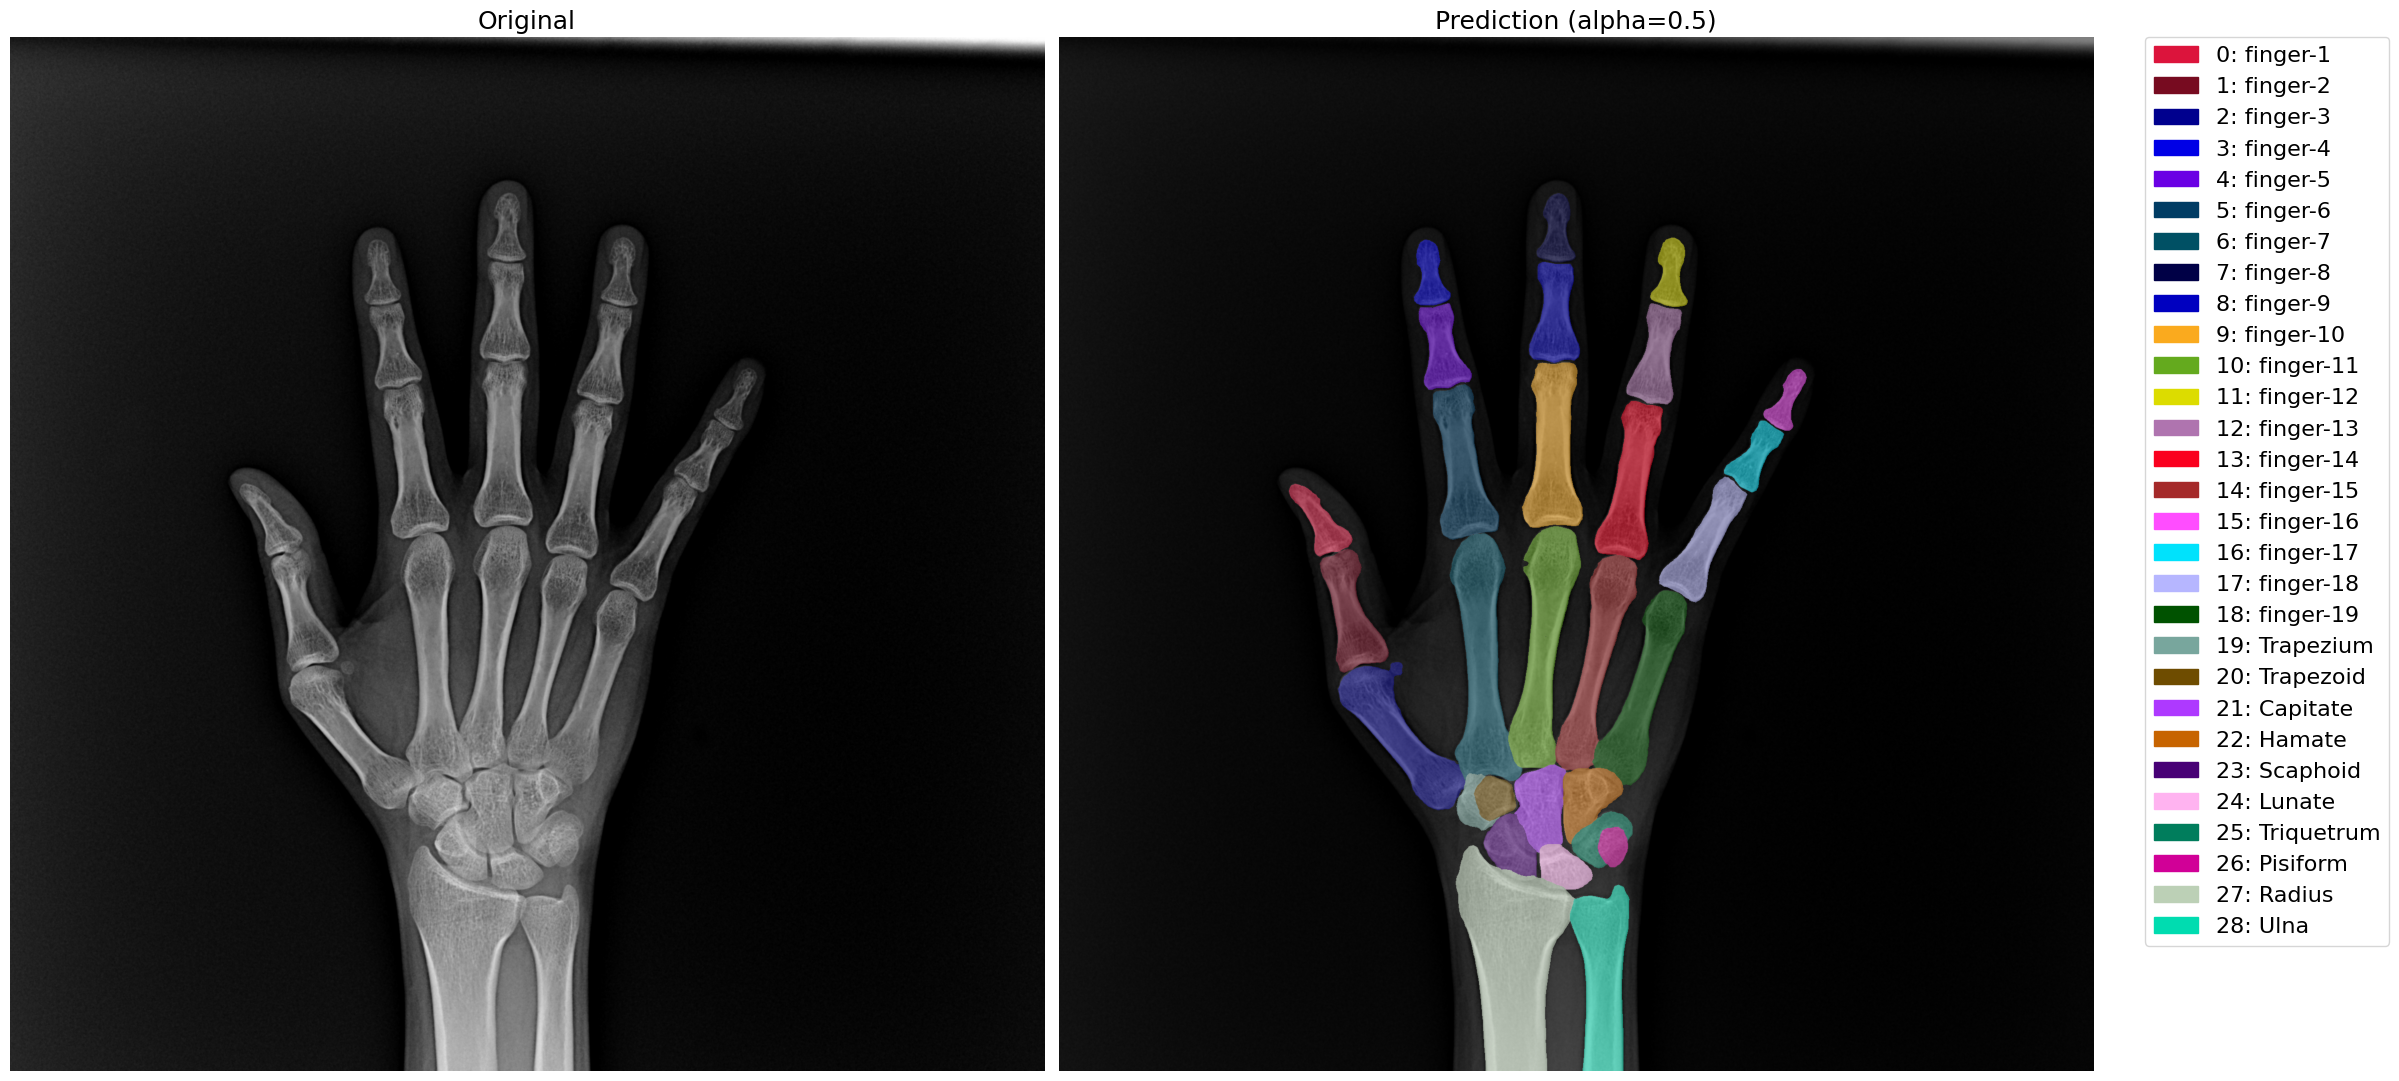

In [45]:
import matplotlib.patches as mpatches

alpha = 0.5

fig, ax = plt.subplots(1, 2, figsize=(24, 12))


ax[0].imshow(image)
ax[0].set_title("Original", fontsize=18)
ax[0].axis("off")


ax[1].imshow(image)                    
ax[1].imshow(label2rgb(preds), alpha=alpha)  
ax[1].set_title(f"Prediction (alpha={alpha})", fontsize=18)
ax[1].axis("off")


handles = []
for i, class_name in enumerate(CLASSES):
    color = np.array(PALETTE[i]) / 255.0
    patch = mpatches.Patch(color=color, label=f"{i}: {class_name}")
    handles.append(patch)

ax[1].legend(
    handles=handles,
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    borderaxespad=0.,
    fontsize=16,
)

plt.tight_layout()
plt.show()

# To CSV

In [46]:
classes, filename = zip(*[x.split("_") for x in filename_and_class])

image_name = [os.path.basename(f) for f in filename]
df = pd.DataFrame({
    "image_name": image_name,
    "class": classes,
    "rle": rles,
})
df.head(30)
df.to_csv("output.csv", index=False)



In [47]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()


# Test one image


In [48]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


In [49]:
def test_one_image_visual(model,image_root,thr=0.5,transforms=None, out_size=(2048, 2048)):
    
    image = cv2.imread(image_root)
    model = model.cuda()
    model.eval()
    
    rles = []
    filename_and_class = []

    image = cv2.imread(image_root)
    image = image / 255.
    
    if transforms is not None:
        inputs = {"image": image}
        result = transforms(**inputs)
        image = result["image"]

    image = image.transpose(2, 0, 1)  
    image_tensor = torch.from_numpy(image).float()
    image_tensor = image_tensor.unsqueeze(0).cuda()
    image_vis = cv2.cvtColor(cv2.imread(image_root), cv2.COLOR_BGR2RGB)

    with torch.no_grad():
        outputs = model(pixel_values=image_tensor).logits
        outputs = F.interpolate(outputs, size=out_size, mode="bilinear", align_corners=False)
        outputs = torch.sigmoid(outputs)
        preds = (outputs > thr).cpu().numpy()[0]

    color_mask = label2rgb(preds)
    alpha = 0.5
    overlay = (image_vis * (1 - alpha) + color_mask * alpha).astype(np.uint8)
    
    fig, ax = plt.subplots(1, 2, figsize=(24, 12))

    ax[0].imshow(image_vis)
    ax[0].set_title("Original", fontsize=18)
    ax[0].axis("off")
    
    ax[1].imshow(overlay)
    ax[1].set_title(f"Overlay (thr={thr})", fontsize=18)
    ax[1].axis("off")
    
    handles = []
    for i, class_name in enumerate(CLASSES):
        color = np.array(PALETTE[i]) / 255.0
        handles.append(mpatches.Patch(color=color, label=f"{i}: {class_name}"))
    
    ax[1].legend(
        handles=handles,
        bbox_to_anchor=(1.05, 1),
        loc="upper left",
        fontsize=14,
    )
    
    plt.tight_layout()
    plt.show()




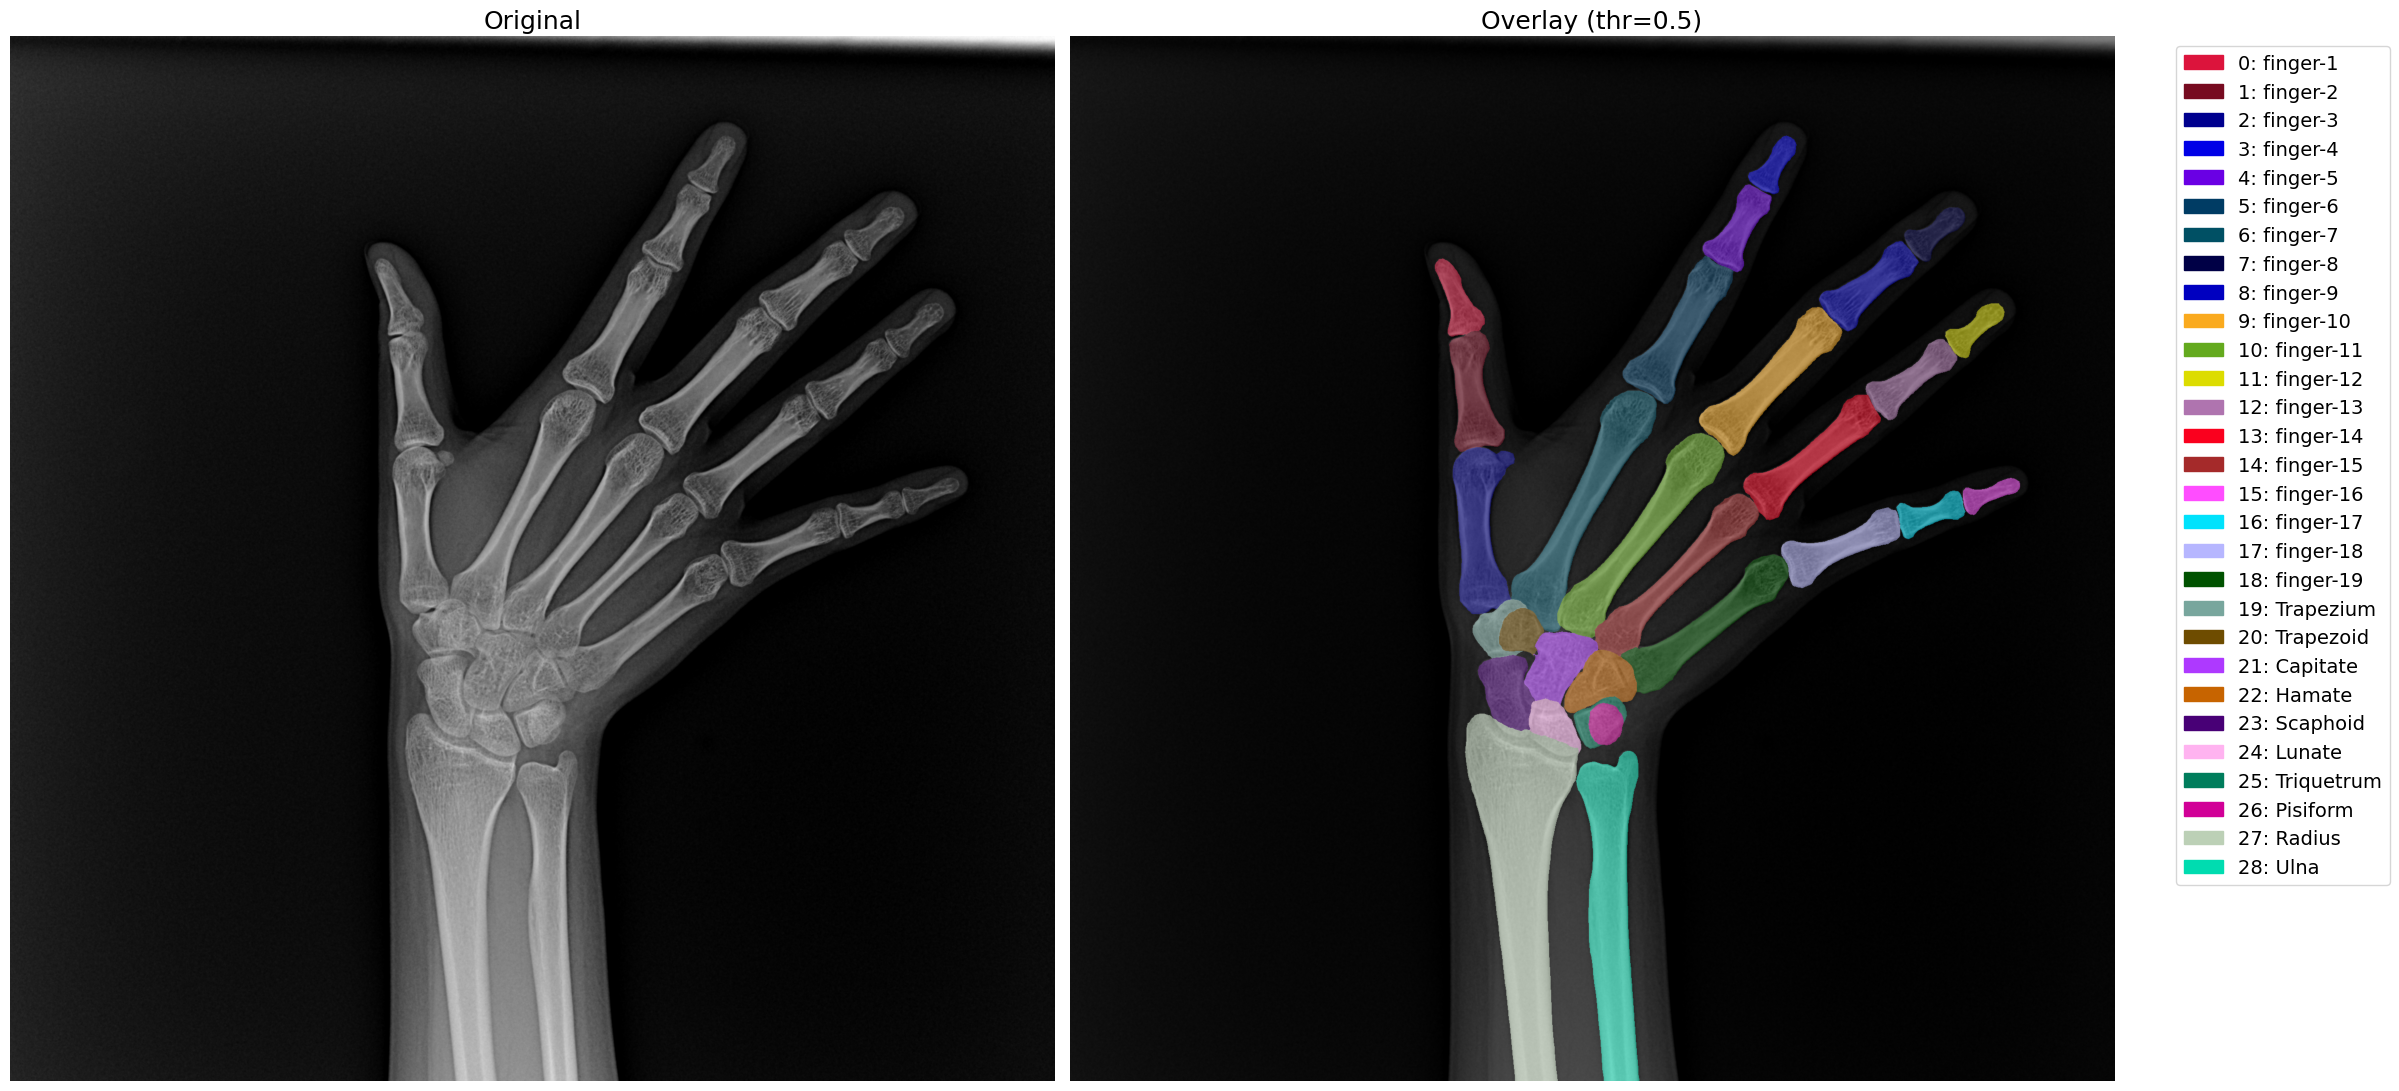

In [50]:
image_root="../data/train_merged/ID283_image1664155969209.png"
# image_root=os.path.join(image_root,os.listdir(image_root)[0])
# print(image_root)
test_one_image_visual(model,
                      image_root,
                      transforms=test_tf,
                      thr=0.5, out_size=(2048, 2048))

# Visualize each class

In [51]:
def test_one_image_visual_with_roi(
    model,
    image_root,
    thr=0.5,
    transforms=None,
    out_size=(2048, 2048),
    roi_classes=None,        # ⭐ bbox + 클래스별 시각화에 사용할 클래스 이름들
    margin=40,
    max_cols=4
):
    """
    - 기존 test_one_image_visual 방식 그대로 사용
    - roi_classes:
        * bbox 계산
        * 클래스별 확률 heatmap 시각화
    """

    assert roi_classes is not None, "roi_classes는 반드시 지정해야 해"

    model = model.cuda()
    model.eval()

    # =========================
    # 1) 기존 코드 그대로: 이미지 → 모델 → preds
    # =========================
    image = cv2.imread(image_root)
    image = image / 255.0

    if transforms is not None:
        inputs = {"image": image}
        result = transforms(**inputs)
        image = result["image"]

    image = image.transpose(2, 0, 1)
    image_tensor = torch.from_numpy(image).float().unsqueeze(0).cuda()

    image_vis = cv2.cvtColor(cv2.imread(image_root), cv2.COLOR_BGR2RGB)

    with torch.no_grad():
        outputs = model(pixel_values=image_tensor).logits
        outputs = F.interpolate(outputs, size=out_size, mode="bilinear", align_corners=False)
        outputs = torch.sigmoid(outputs)                  # (1,C,H,W)
        probs = outputs.cpu().numpy()[0]                  # (C,H,W)
        preds = (probs > thr).astype(np.uint8)            # (C,H,W)

    # =========================
    # 2) 기존 방식 그대로: overlay
    # =========================
    roi_indices = [CLASSES.index(name) for name in roi_classes]
    
    # 🔴 나머지 클래스는 전부 0
    preds_roi = np.zeros_like(preds, dtype=np.uint8)
    preds_roi[roi_indices] = preds[roi_indices]
    
    # roi_classes만 색칠
    color_mask = label2rgb(preds_roi)
    
    alpha = 0.5
    overlay = (
        image_vis.astype(np.float32) * (1 - alpha)
        + color_mask.astype(np.float32) * alpha
    ).astype(np.uint8)

    # =========================
    # 3) ROI bbox 계산 (roi_classes 사용)
    # =========================
    roi_indices = [CLASSES.index(name) for name in roi_classes]

    # union mask (binary)
    union = np.zeros_like(preds[0], dtype=bool)
    for idx in roi_indices:
        union |= (preds[idx] == 1)

    ys, xs = np.where(union)
    bbox = None
    if len(xs) > 0 and len(ys) > 0:
        y1, y2 = ys.min(), ys.max()
        x1, x2 = xs.min(), xs.max()

        H, W = union.shape
        y1 = max(0, y1 - margin)
        x1 = max(0, x1 - margin)
        y2 = min(H - 1, y2 + margin)
        x2 = min(W - 1, x2 + margin)

        bbox = (x1, y1, x2, y2)

    # =========================
    # 4) Overlay + bbox 시각화
    # =========================
    fig, ax = plt.subplots(1, 2, figsize=(24, 12))

    ax[0].imshow(image_vis)
    ax[0].set_title("Original", fontsize=18)
    ax[0].axis("off")

    ax[1].imshow(overlay)
    ax[1].set_title(f"Overlay (thr={thr})", fontsize=18)
    ax[1].axis("off")

    if bbox is not None:
        x1, y1, x2, y2 = bbox
        rect = plt.Rectangle(
            (x1, y1),
            (x2 - x1 + 1),
            (y2 - y1 + 1),
            fill=False,
            linewidth=3
        )
        ax[1].add_patch(rect)

    handles = []
    for name in roi_classes:
        idx = CLASSES.index(name)
        color = np.array(PALETTE[idx]) / 255.0
        handles.append(mpatches.Patch(color=color, label=f"{idx}: {name}"))

    ax[1].legend(
        handles=handles,
        bbox_to_anchor=(1.05, 1),
        loc="upper left",
        fontsize=12,
    )

    plt.tight_layout()
    plt.savefig("inference.png")
    plt.show()

    # =========================
    # 5) 클래스별 확률 Heatmap (ROI crop)
    # =========================
    if bbox is None:
        print("[warn] ROI bbox를 찾지 못해 클래스별 시각화를 건너뜀")
        return preds

    x1, y1, x2, y2 = bbox
    preds_crop = preds[:, y1:y2+1, x1:x2+1]

    K = len(roi_indices)
    cols = min(max_cols, K)
    rows = int(np.ceil(K / cols))

    fig2, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
    axes = np.array(axes).reshape(rows, cols)

    for k, cls_idx in enumerate(roi_indices):
        r, c = divmod(k, cols)
        hm = preds_crop[cls_idx]

        im = axes[r, c].imshow(hm, vmin=0.0, vmax=1.0)
        axes[r, c].set_title(
            f"{cls_idx}: {CLASSES[cls_idx]}\nmean={hm.mean():.3f}",
            fontsize=12
        )
        axes[r, c].axis("off")
        plt.colorbar(im, ax=axes[r, c], fraction=0.046, pad=0.04)

    for k in range(K, rows * cols):
        r, c = divmod(k, cols)
        axes[r, c].axis("off")

    plt.tight_layout()
    
    plt.show()

    return preds


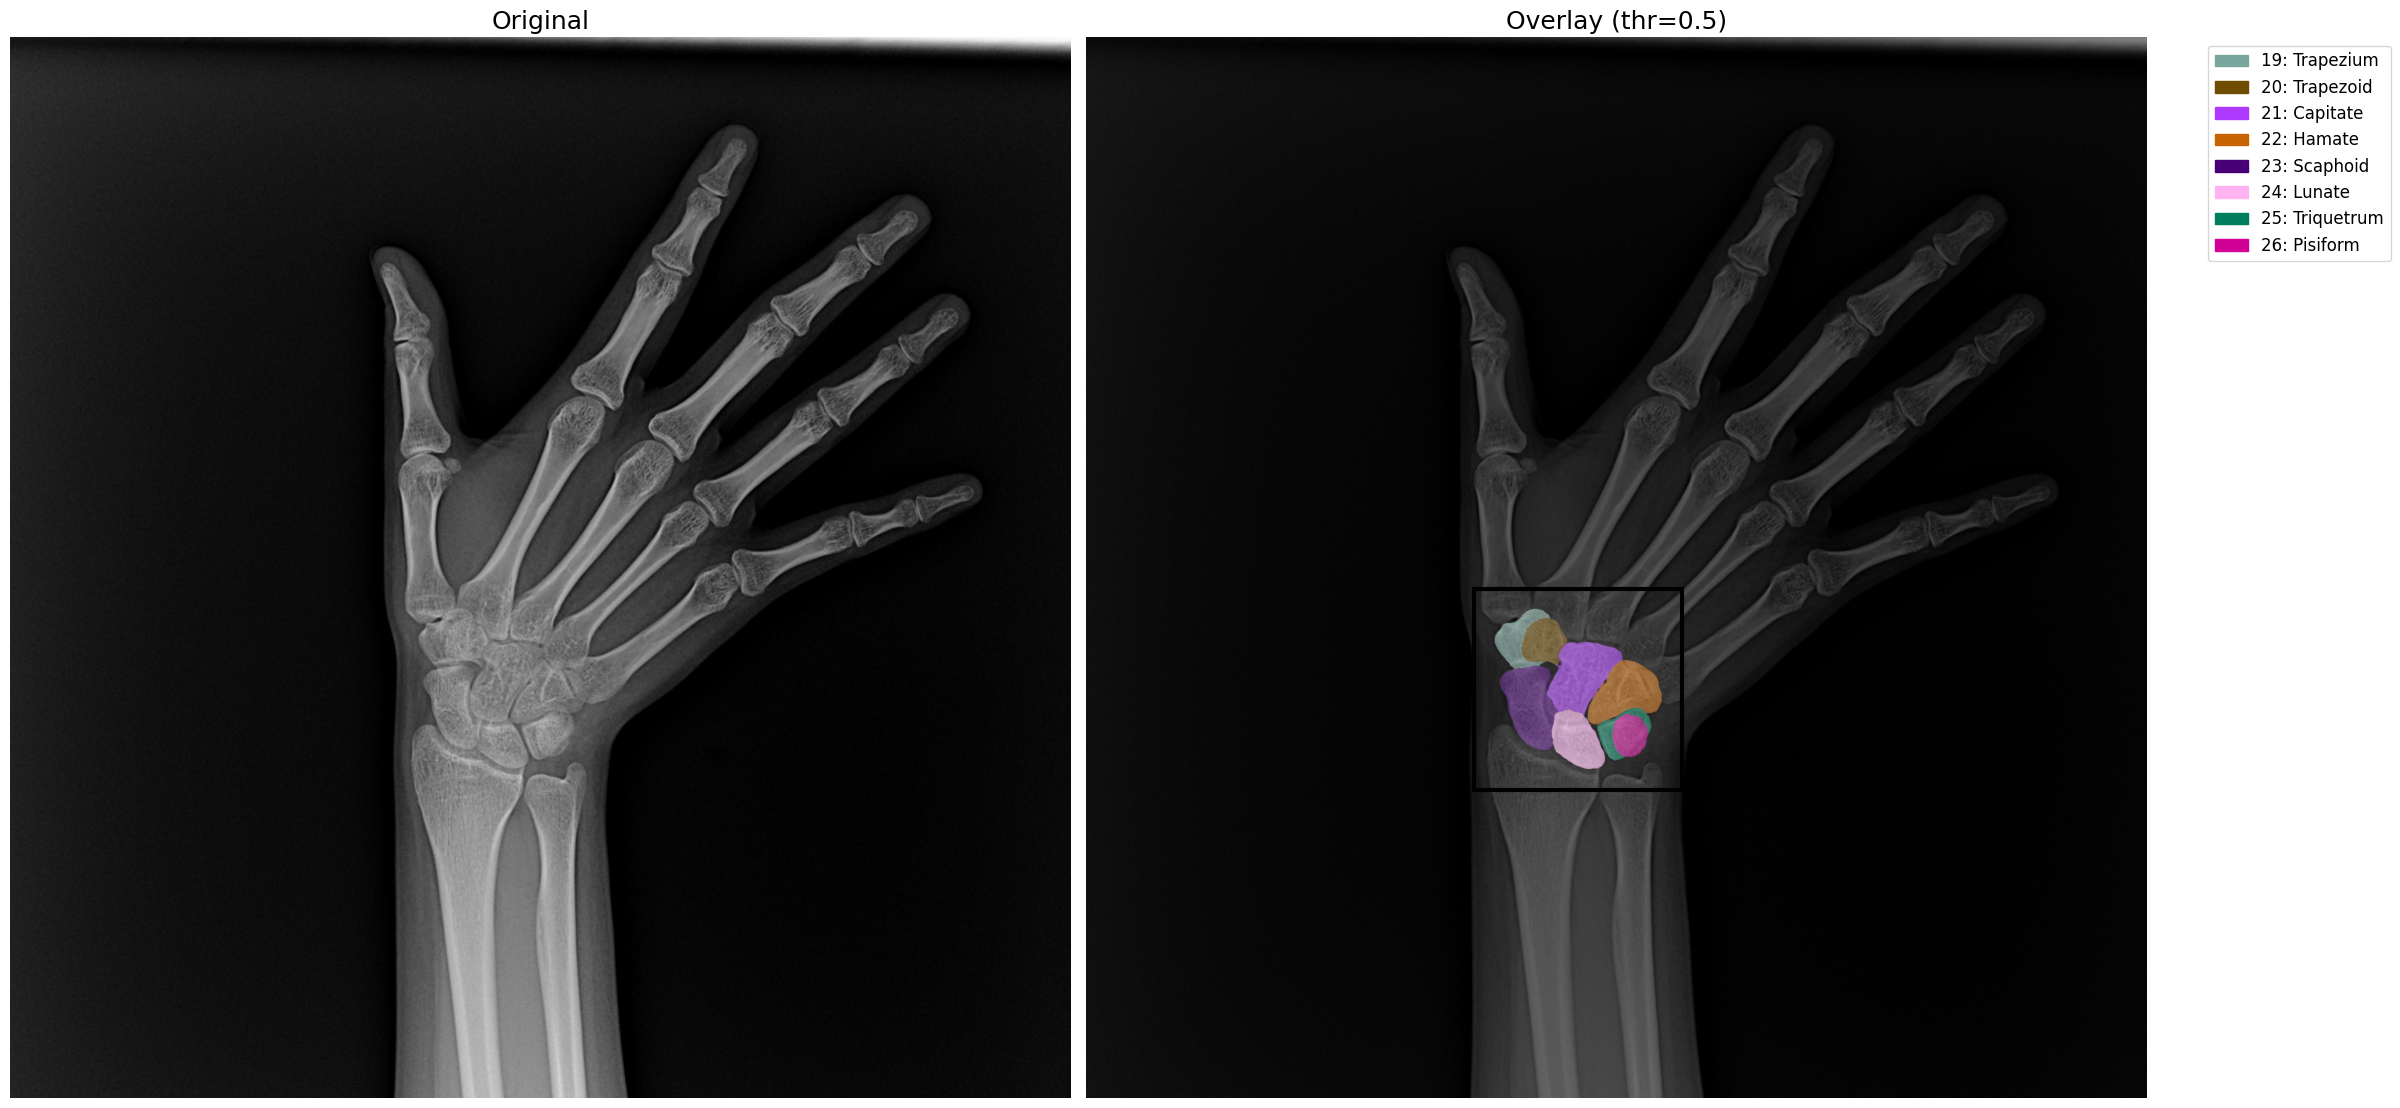

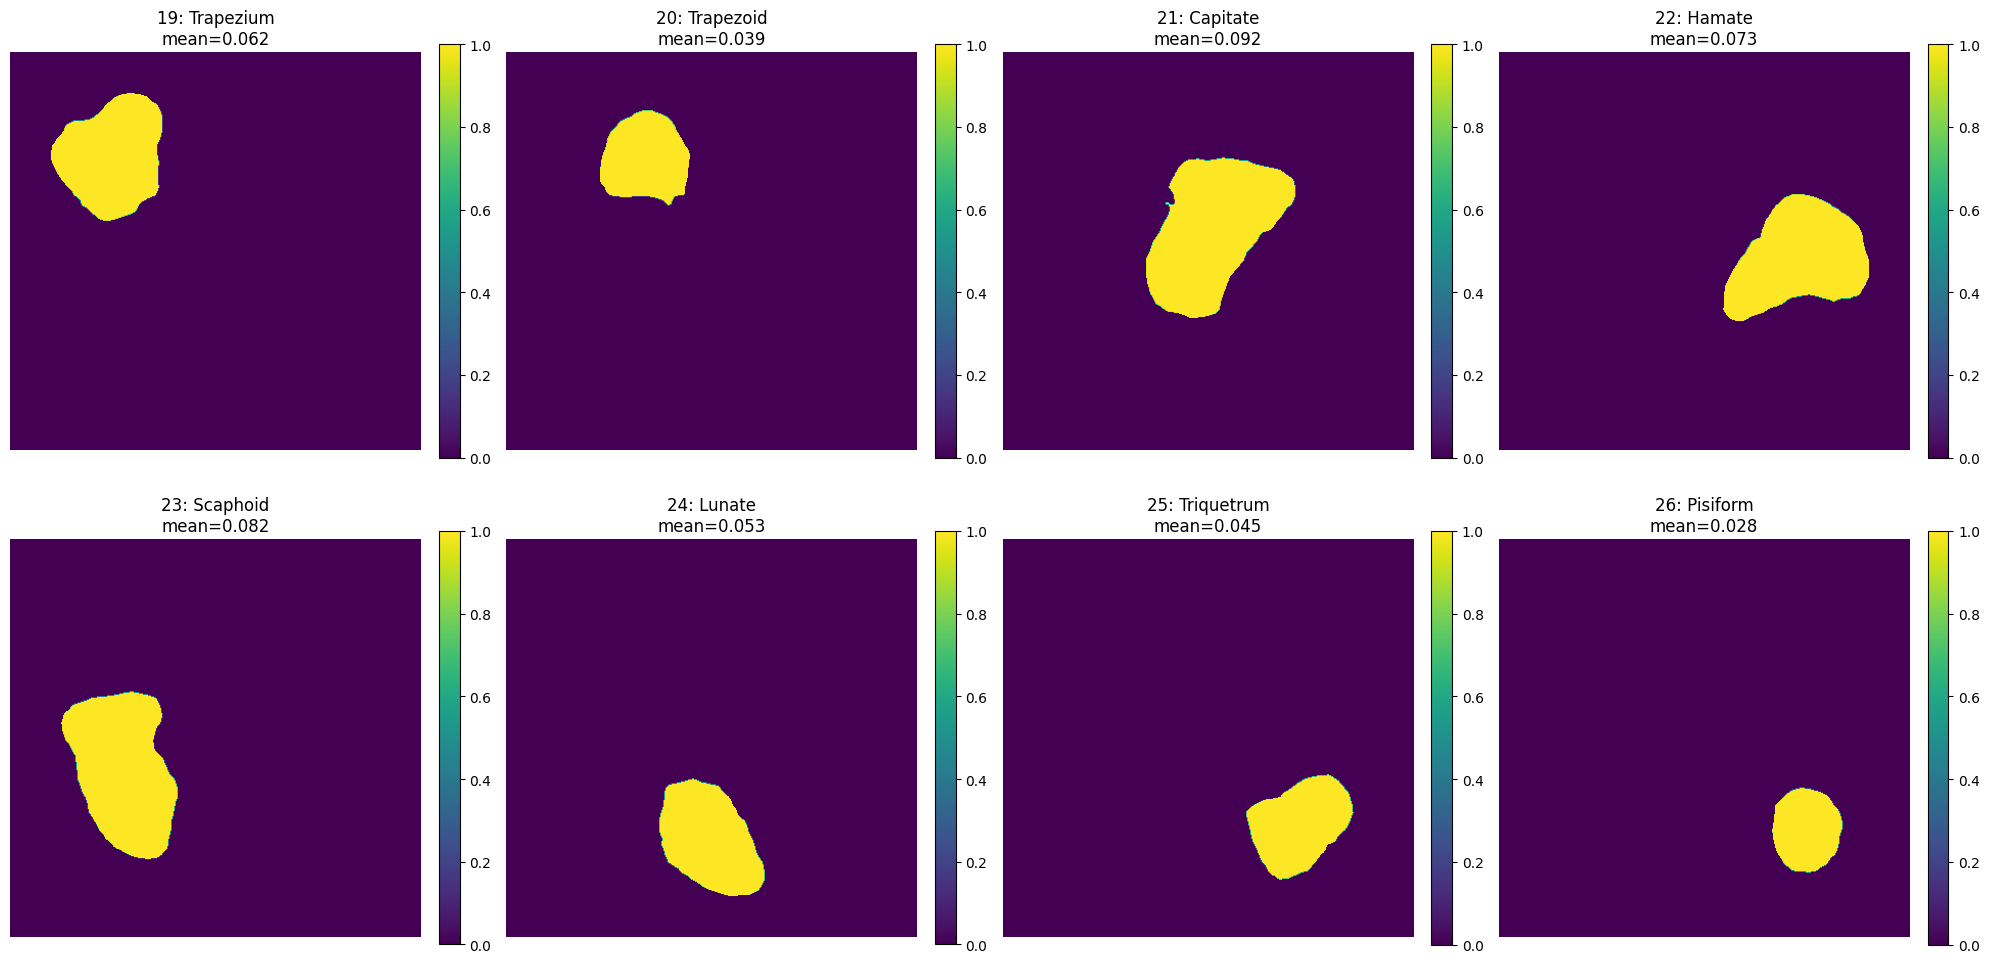

In [52]:
roi_classes = ["Trapezium", "Trapezoid", "Capitate", "Hamate",
               "Scaphoid", "Lunate", "Triquetrum", "Pisiform"]

# ROI bbox도 이걸로 잡고, 시각화도 이걸로 하고 싶으면 vis_class_names=None

preds = test_one_image_visual_with_roi(
    model,
    image_root,
    thr=0.5,
    transforms=test_tf,
    out_size=(2048, 2048),
    roi_classes=roi_classes
)

In [53]:
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


def _bbox_from_union_mask(label_chw, class_indices, margin=40):
    union = np.zeros_like(label_chw[0], dtype=bool)
    for idx in class_indices:
        union |= (label_chw[idx] == 1)

    ys, xs = np.where(union)
    if len(xs) == 0 or len(ys) == 0:
        return None

    y1, y2 = ys.min(), ys.max()
    x1, x2 = xs.min(), xs.max()

    H, W = union.shape
    y1 = max(0, y1 - margin)
    x1 = max(0, x1 - margin)
    y2 = min(H - 1, y2 + margin)
    x2 = min(W - 1, x2 + margin)

    if x2 <= x1 or y2 <= y1:
        return None
    return (x1, y1, x2, y2)


def load_gt_from_image_and_label(image_root, label_root):
    """
    return:
      image_rgb: (H,W,3) uint8
      label_chw: (C,H,W) uint8
    """
    image_bgr = cv2.imread(image_root)
    if image_bgr is None:
        raise FileNotFoundError(image_root)

    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    H, W = image_rgb.shape[:2]

    label_hwc = np.zeros((H, W, len(CLASSES)), dtype=np.uint8)

    with open(label_root, "r") as f:
        data = json.load(f)

    for ann in data["annotations"]:
        cname = ann["label"]
        if cname not in CLASS2IND:
            continue

        idx = CLASS2IND[cname]
        pts = np.array(ann["points"], dtype=np.int32)

        m = np.zeros((H, W), dtype=np.uint8)
        cv2.fillPoly(m, [pts], 1)
        label_hwc[..., idx] = m

    return image_rgb, label_hwc.transpose(2, 0, 1)


def visualize_gt_roi_only(
    image_root,
    label_root,
    roi_classes,
    margin=40,
    max_cols=4,
    alpha=0.5
):
    image_vis, label_chw = load_gt_from_image_and_label(image_root, label_root)

    roi_indices = [CLASSES.index(n) for n in roi_classes]

    # roi_classes만 남기기
    label_roi = np.zeros_like(label_chw, dtype=np.uint8)
    label_roi[roi_indices] = label_chw[roi_indices]

    # =========================
    # Overlay + bbox
    # =========================
    color_mask = label2rgb(label_roi)   # 네가 정의한 label2rgb
    overlay = (image_vis.astype(np.float32) * (1 - alpha)
               + color_mask.astype(np.float32) * alpha).astype(np.uint8)

    bbox = _bbox_from_union_mask(label_roi, roi_indices, margin=margin)

    fig, ax = plt.subplots(1, 2, figsize=(24, 12))

    ax[0].imshow(image_vis)
    ax[0].set_title("Original", fontsize=18)
    ax[0].axis("off")

    ax[1].imshow(overlay)
    ax[1].set_title("GT Overlay (roi_classes only)", fontsize=18)
    ax[1].axis("off")

    if bbox is not None:
        x1, y1, x2, y2 = bbox
        rect = plt.Rectangle((x1, y1), x2-x1+1, y2-y1+1,
                              fill=False, linewidth=3)
        ax[1].add_patch(rect)
    else:
        print("[warn] ROI bbox를 찾지 못함")

    handles = []
    for name in roi_classes:
        idx = CLASSES.index(name)
        handles.append(
            mpatches.Patch(color=np.array(PALETTE[idx]) / 255.0,
                            label=f"{idx}: {name}")
        )

    ax[1].legend(handles=handles,
                 bbox_to_anchor=(1.05, 1),
                 loc="upper left",
                 fontsize=12)

    plt.tight_layout()
    plt.show()

    # =========================
    # bbox crop + 클래스별 시각화 (네 블록 그대로)
    # =========================
    if bbox is None:
        print("[warn] ROI bbox를 찾지 못해 클래스별 시각화를 건너뜀")
        return

    x1, y1, x2, y2 = bbox
    label_crop = label_roi[:, y1:y2+1, x1:x2+1]

    K = len(roi_indices)
    cols = min(max_cols, K)
    rows = int(np.ceil(K / cols))

    fig2, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
    axes = np.array(axes).reshape(rows, cols)

    for k, cls_idx in enumerate(roi_indices):
        r, c = divmod(k, cols)
        hm = label_crop[cls_idx].astype(np.float32)

        im = axes[r, c].imshow(hm, vmin=0.0, vmax=1.0)
        axes[r, c].set_title(
            f"{cls_idx}: {CLASSES[cls_idx]}\nmean={hm.mean():.3f}",
            fontsize=12
        )
        axes[r, c].axis("off")
        plt.colorbar(im, ax=axes[r, c], fraction=0.046, pad=0.04)

    for k in range(K, rows * cols):
        r, c = divmod(k, cols)
        axes[r, c].axis("off")

    plt.tight_layout()
    plt.show()


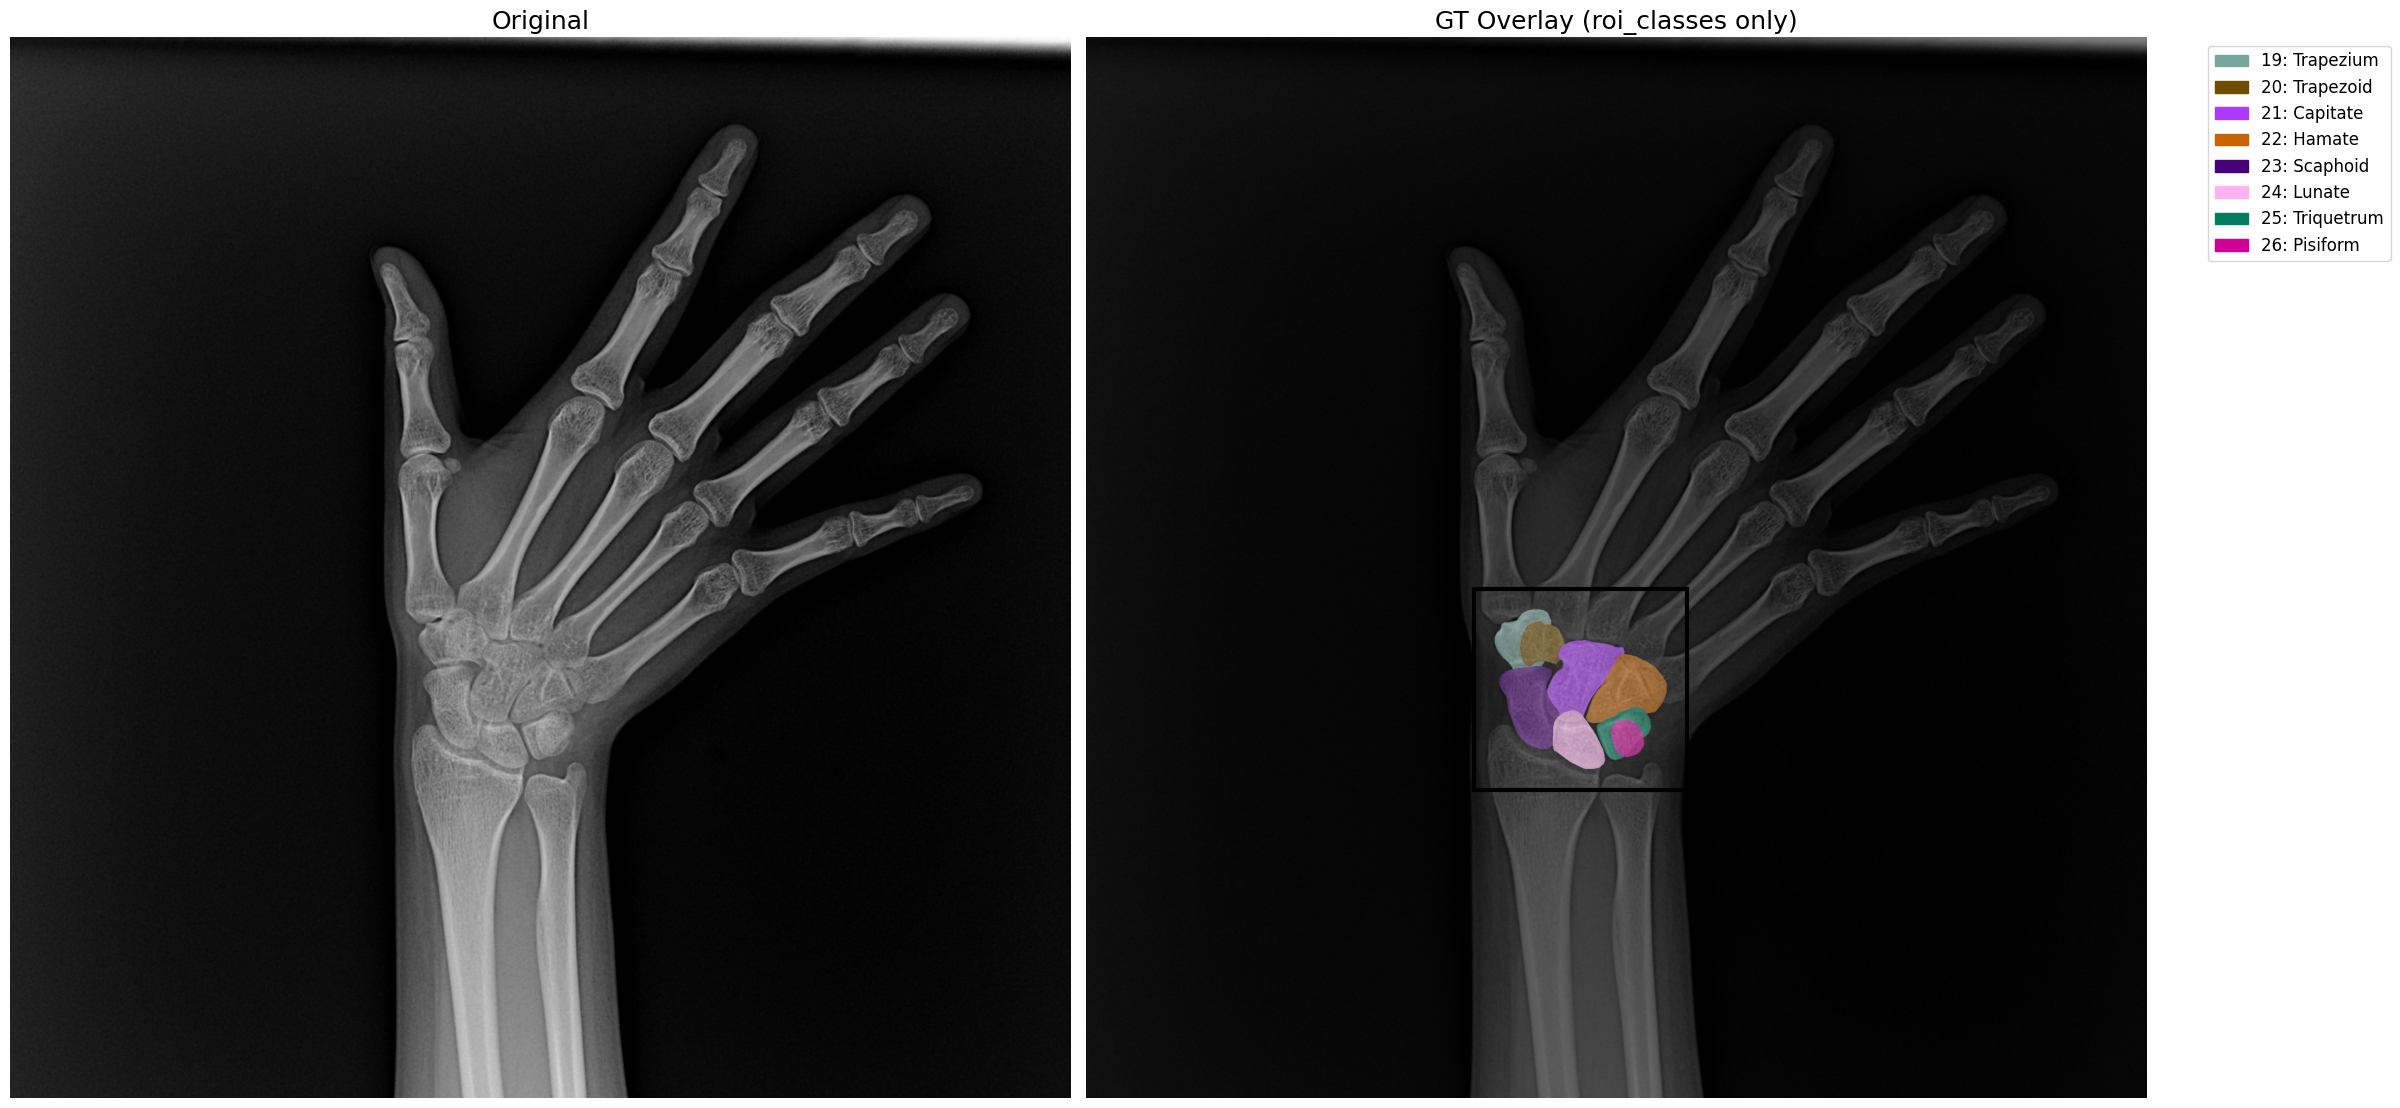

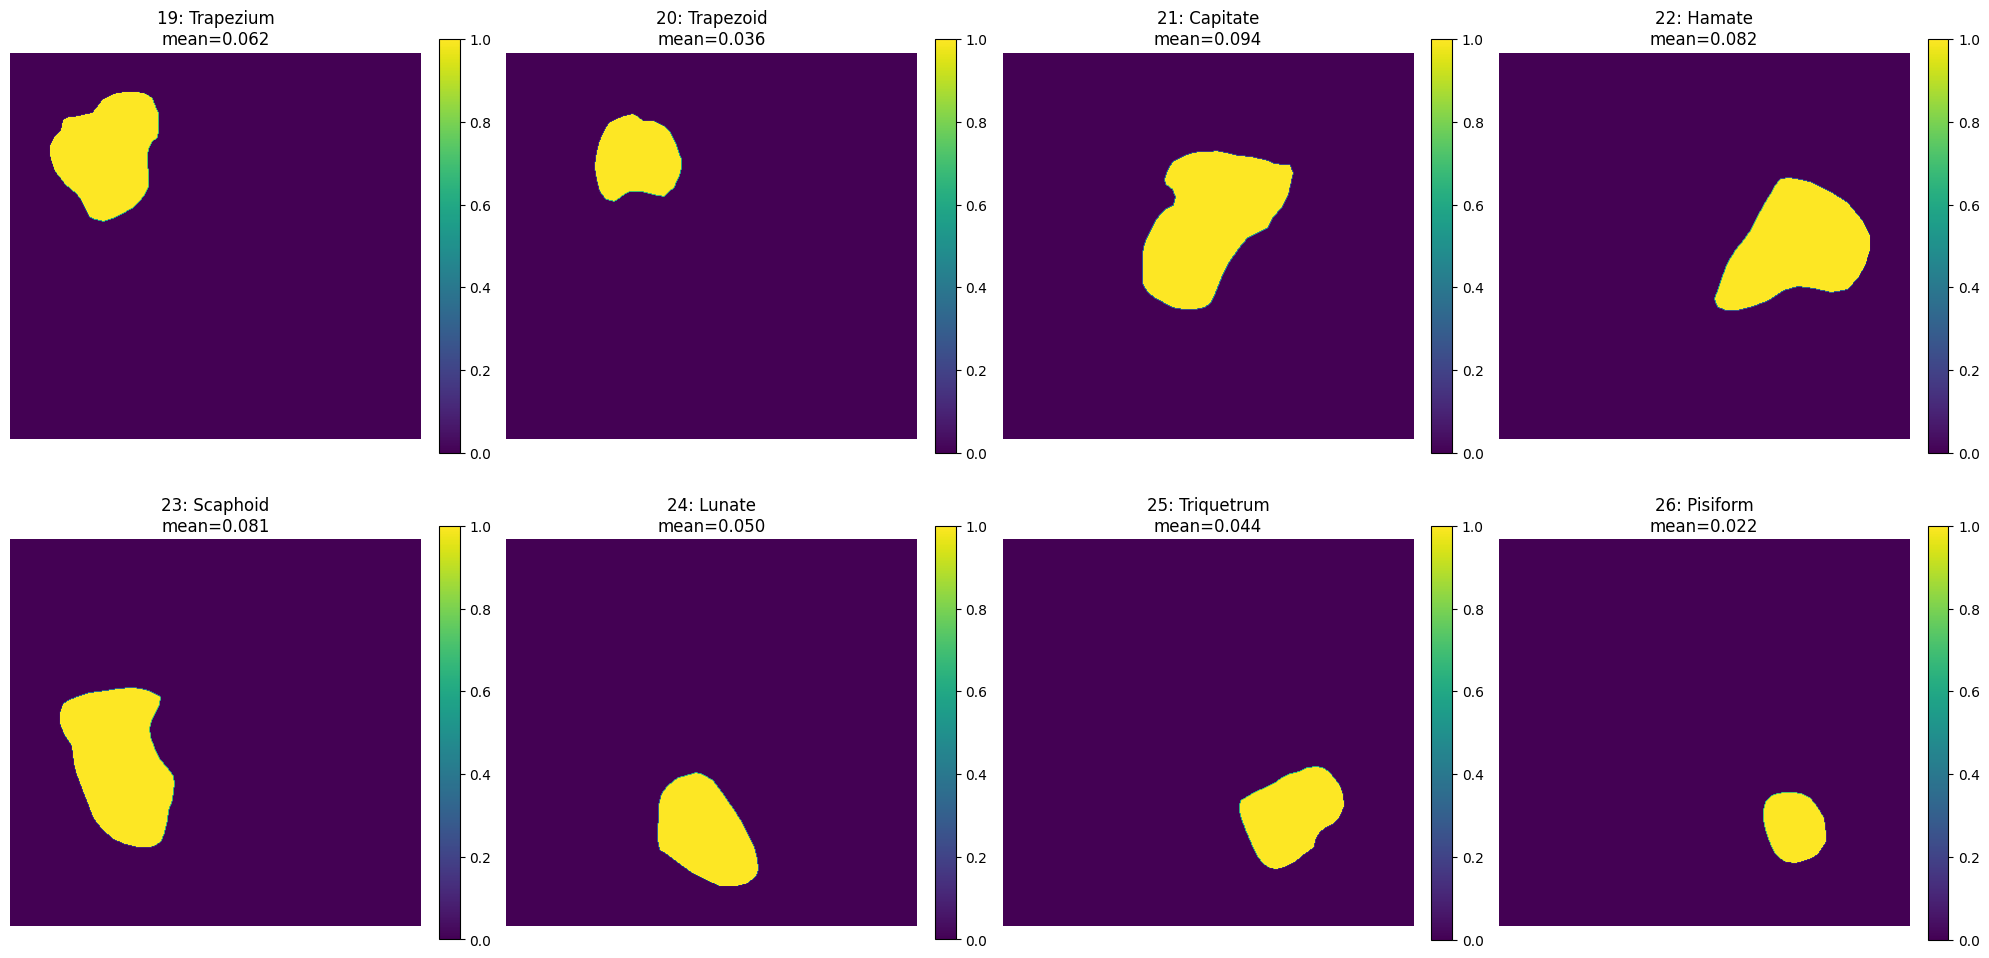

In [54]:
visualize_gt_roi_only(
    image_root="../data/train_merged/ID283_image1664155969209.png",
    label_root="../data/train_merged/ID283_image1664155969209.json",
    roi_classes=roi_classes,
    margin=40,
    max_cols=4
)